### Project assignment: GA-Fuzzy System for Trading Crude Palm Oil Futures
Implementing the paper: "Quantified moving average strategy of crude oil futures
market based on fuzzy logic rules and genetic algorithms"
* Based on a trading rule called Fuzzy Moving Average Strategy (FMAS).
* Fuzzy logic rule and Moving Average Strategy (MAS) are combined for trading.

### Trading platform configuration
Backtrader is Python based backtesting/trading platform for developing home cooked indicators and trading strategies.

The basics of running this platform:

1. Create a Strategy
1. Decide on potential adjustable parameters
1. Instantiate the Indicators you need in the Strategy
1. Write down the logic for entering/exiting the market

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pylab as pylab
import csv

import pytz
import random
from os import listdir
from os.path import isfile, join

import skfuzzy as fuzz
from skfuzzy import control as ctrl
import math

import pdb
import operator
import time

In [29]:
def getFilesAndNames(dirpath):
    ''' Return only the Futures files from the directory'''
    onlyfiles = []
    for f in listdir(dirpath):
        fullpath = join(dirpath, f)
        if isfile(fullpath) and f.endswith("csv"):
            onlyfiles.append((fullpath,f.split(".")[0]))
    #print (onlyfiles)
    return onlyfiles

#getFilesAndNames(join(os.getcwd(),"Data"))

In [30]:
def getDataPath():
    return join(os.getcwd(),"Data")
    

In [31]:
# setup data
def setup_multiple_data(bt, cerebro, bTestMode):
    modPath = getDataPath()
    if bTestMode:
        modPath = join(modPath,"Test")
    else:
        modPath = join(modPath,"Prod")
    
    datalist = getFilesAndNames(modPath)
    
    #print (datalist)
    
    for i in range(len(datalist)):
        df = pd.read_csv(datalist[i][0])
        
       # print (df)
        
        start_test = datetime.datetime.strptime(df['DateTime'][0], "%d/%m/%Y %H:%M")
        end_test = datetime.datetime.strptime(df['DateTime'][len(df)-1], "%d/%m/%Y %H:%M")
        
        # setup the data path
        #datafile = "FCPO_6_years_NUS.xlsx"
        data = bt.feeds.GenericCSVData(
            dataname=datalist[i][0],
            fromdate= start_test,
            todate= end_test,
            nullvalue=0.0,
            dtformat=('%d/%m/%Y %H:%M'),
            tz = pytz.timezone('Asia/Jakarta'),
            datetime=2,
            high=4,
            low=5,
            open=3,
            close=6,
            volume=7#
        )
        # Add the Data Feed to Cerebro
        cerebro.adddata(data, name=datalist[i][1])
        
        return

#setup_multiple_data(bt, bt.Cerebro(), False)

### Trading rules
Initial allocation 10 million Malaysian Ringgit.
Trading cost per trade is maximum of (RM30, 0.2% x volume x price)

Short(sell order) incurs additional borrowing cost: 0.01% daily interest accrual based on original market value of borrowed positions from the short day, to be deducted from balance, (immediatelyafter short sell on the short day, and then at the beginning of a next new day onwards), until fully buying back/returning the borrowed positions.

In [32]:
def setup_platform(cerebro):
    ''' Setup the rules of engagement'''
    # Set our desired cash start, using MYR
    cerebro.broker.setcash(10000000.0)

    # Set the commission - max of 0.2% or RM30
    comminfo = CommInfo_Fut_Perc_Mult(
        commission=0.002,#,  # 0.2%
        mult=1, #lot size for futures trading
        margin = 4000, #Bursa malaysia futures margin cost
        interest = 0.01 #short selling interest
    )

    cerebro.broker.addcommissioninfo(comminfo)

In [33]:
class CommInfo_Fut_Perc_Mult(bt.CommInfoBase):
    def _getcommission(self, size, price, pseudoexec):
        return max(30, size * price * self.p.commission * self.p.mult)

In [34]:
def setup_plot():
    pylab.rcParams['figure.figsize'] = 45, 30  # that's default image size for this interactive session
    pylab.rcParams['font.family'] = 'sans-serif'
    pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
    pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
    pylab.rcParams["font.size"] = "200"

### About the data
* Prices and trading volume for 37 Crude Palm Oil (FCPO) Futures
* 6 years per minute data
* Date from 2011 JAN 03 10:30 to 2016 DEC 30 17:59
* 355,959 valid records
* General: The financial instrumentcode for FCPO
* Price unit: Malaysian Ringgit
* Volume unit: thousands
* Volume data is from one broker only, not aggregation of entire FCPO market players.

In [35]:
modpath = join(getDataPath(),"Test")
datalist = getFilesAndNames(modpath)
df = pd.read_csv(datalist[0][0])

In [36]:
# Sort DataFrame by date
df = df.sort_values('DateTime')

# Double check the result
df.head()

,Date,Time,DateTime,Open,High,Low,Close,Volume
97365,20121001,10:30:00,1/10/2012 10:30,2508,2516,2508,2516,6
97366,20121001,10:31:00,1/10/2012 10:31,2516,2516,2516,2516,4
97367,20121001,10:32:00,1/10/2012 10:32,2513,2513,2510,2510,31
97368,20121001,10:33:00,1/10/2012 10:33,2510,2510,2507,2507,39
97369,20121001,10:34:00,1/10/2012 10:34,2506,2506,2504,2504,30


Test data is 3 years worth of data starting from 2011 JAN 03.

In [37]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plotrange = 500
plt.xticks(range(0,df.shape[0],plotrange),df['Date'].loc[::plotrange],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

KeyboardInterrupt: 

### Helper functions can be found here
This section contains the generic function used in this notebook.

In [ ]:
# https://stackoverflow.com/questions/9489078/how-to-split-a-huge-csv-file-based-on-content-of-first-column
import csv
from itertools import groupby

def split_excel_to_csv():
    datafile = 'FCPO_6_years_NUS.csv'
    modpath = getDataPath()
    datapath = join(modpath, datafile)
    csv_header = 'Date,Time,DateTime,Open,High,Low,Close,Volume'
    reader = csv.reader(open(datapath))
    next(reader)
    for key, rows in groupby(reader,lambda row: row[0]):
        if key[-1] in ["1","2","3"]:
            outputpath = join(modpath,"Test","{}.csv".format(key))
        else:
            outputpath = join(modpath,"Prod","{}.csv".format(key))
        with open(outputpath, "w") as output:
            output.write(csv_header + "\n")
            for row in rows:
                row.pop(0) # remove the key
                output.write(",".join(row) + "\n")
                
#split_excel_to_csv()

In [ ]:
def writeToCsv(filepath, data):
    ''' Generate a csv file which contains the seven fuzzy extent centroid value'''
    with open(filepath,'w') as f:
        #print ("max {} and min {}".format(max(data), min(data)))
        f.write(",".join(map(str,splitDataToSevenExtents(data))))
        
def loadFromCsv(filepath):
    ''' Load the previous stored fuzzy extent values from csv file'''
    with open(filepath, 'rt') as f:
        reader = csv.reader(f)
        return list(map(float,[r for r in reader][0]))

In [ ]:
def splitDataToSevenExtents(data):
    ''' Split a list of array into seven parts meant for the fuzzy extent later
        Calculate the central point and also the std dev '''
    # get the max and min
    max_point = max(data)
    # split the positive into three parts
    min_point = min(data)
    # split the negative into three parts
    pos_part = 0
    if max_point > 0:
        pos_part = math.ceil(max_point / 3)
    neg_part = 0
    if min_point < 0:
        neg_part = math.floor(min_point / 3)
    
    return [neg_part * 3,
            neg_part * 2,
            neg_part,
            0,
            pos_part,
            pos_part * 2,
            pos_part * 3]

In [ ]:
def generateAllCombinationsIndividuals():
    ''' Use to cache the fuzzy system model'''
    inds = ['sma','ama','tma','tpma']
    m = np.array([10, 20, 50, 100, 150, 200])
    n = np.array([3,5,10,15,20])
    ext = "M"
    rec = 0
    count = 0
    pop = dict()
    for count,i in enumerate(inds):
        rules = []
        for slow in m:
            for fast in n:
                if fast < slow:
                    rule = [i, fast, slow, ext, rec]
                    rules.append(rule)
                    
        pop[count] = {"individual":np.array(rules)}
    return pop
        
#generateAllCombinationsIndividuals()

In [ ]:
def generateRandomRule():
    ''' generate one random rule'''
    inds = ['sma','ama','tma','tpma']
    m = np.array([10, 20, 50, 100, 150, 200])
    n = np.array([3,5,10,15,20])
    exts = ['VL','EL','L','M','H','VH','EH']
    neg = np.arange(-1,0,0.1)
    med = np.arange(-1,1,0.1)
    pos = np.arange(0,1,0.1)
    precision = 2

    sel_ext = random.choice(exts)
    rec = 0
    if sel_ext in ['VL','EL','L']:
        rec = round(random.choice(neg), precision)
    elif sel_ext in ['M']:
        rec = round(random.choice(med), precision)
    else:
        rec = round(random.choice(pos), precision)
        
    fast = random.choice(n)
    slow = random.choice(m[m>fast])

    return [random.choice(inds), fast, slow, sel_ext, rec]
    
#print (generateRandomRule())

def generateRandomIndividual():
    rules = []
    total_rules = 10
    for i in range(0,total_rules):
        rules.append(generateRandomRule())
    
    return {"individual":np.array(rules)}

#print (generateRandomIndividual())

def generateRandomPopulation(size=20):
    population = dict()
    for i in range(0,size):
        population[i] = generateRandomIndividual()
    return population

#pop= generateRandomPopulation()

In [ ]:
# https://stackoverflow.com/questions/5998245/get-current-time-in-milliseconds-in-python
def getStartTime():
    t0 = time.time()
    return t0

def getEndTime(t0, funcName, threshold=50):
    t1 = time.time()
    totaltime = (t1-t0) * 1000 # in micro seconds
    if totaltime > threshold:
        print ("Total running time for function {} is {} ms".format(funcName,totaltime))
       # raise
    return totaltime

### Fuzzy Logic rule
The moving average provides the buy or sell signals. If we only use the moving average strategy,we must make decisions
immediately when the two moving average lines cross over. This method has large risks and may cause extra costs and
losses. Some researchers set a range parameter to make decisions until the differences of the two moving averages exceed
a certain range. By using the fuzzy logical rule, we cannot only set a range parameter, but also make the parameter change
along with different situations. The fuzzy logic rule is essential to precisely describe and process the fuzziness object. It extends the ordinary set, which take two values (0 and 1). The fuzzy set can take infinite values of [0, 1]. In addition, the concept ‘‘membership’’ is used to accurately portray the relation between elements and the fuzzy set.

In [ ]:
def buildFuzzySystem(arr, bShowPlot=False, bDebug=False):
    '''Given an array of value, build and return a fuzzy system'''
    # New Antecedent/Consequent objects hold universe variables and membership functions

    feModel = ctrl.Antecedent(np.arange(arr[0], arr[-1], 0.1), 'feModel')
    recModel = ctrl.Consequent(np.arange(-1, 1, 0.1), 'recModel')

    recModel["Neg"] = fuzz.pimf(recModel.universe, -1, -1, -1, 0)
    recModel["Med"] = fuzz.pimf(recModel.universe, -1, 0, 0, 1)
    recModel["Pos"] = fuzz.pimf(recModel.universe, 0, 1, 1, 1)
    
    feModel["EL"] = fuzz.pimf(feModel.universe, arr[0], arr[0], arr[0],arr[1])
    feModel["VL"] = fuzz.pimf(feModel.universe, arr[0], arr[1], arr[1], arr[2])
    feModel["L"] = fuzz.pimf(feModel.universe, arr[1], arr[2], arr[2], arr[3])
    feModel["M"] = fuzz.pimf(feModel.universe, arr[2], arr[3], arr[3], arr[4])
    feModel["H"] = fuzz.pimf(feModel.universe, arr[3], arr[4], arr[4], arr[5])
    feModel["VH"] = fuzz.pimf(feModel.universe, arr[4], arr[5], arr[5], arr[6])
    feModel["EH"] = fuzz.pimf(feModel.universe, arr[5], arr[6], arr[6], arr[6])

    if bShowPlot:
        recModel.view()
        feModel.view()
    
    if bDebug:
        print (type(recModel))
        print (type(feModel))

    #build the rules
    rule1 = ctrl.Rule(feModel["EL"] | feModel["L"] | feModel["VL"], recModel["Neg"])
    rule2 = ctrl.Rule(feModel["M"], recModel["Med"])
    rule3 = ctrl.Rule(feModel["EH"] | feModel["H"] | feModel["VH"], recModel["Pos"])
    
    ctrl_sys = ctrl.ControlSystem([rule1, rule2, rule3])
    ctrl_instance = ctrl.ControlSystemSimulation(ctrl_sys)
    
    return ctrl_instance, feModel, recModel

In [ ]:
def getFuzzyOutput(ctrl_instance, feModel, recModel, input_val, bShowPlot=False, bDebug=False):
    ''' Given the fuzzy system and the input value, compute and return the mf and the fuzzy extent'''

    ext = ""
    rec = 0
    ants = []
    try:
        ctrl_instance.input['feModel'] = input_val
        ctrl_instance.compute()

        if bShowPlot:
            recModel.view(sim=ctrl_instance)
            feModel.view(sim=ctrl_instance)
    
        ants = ctrl_instance.get_antecedents()
        
        if bDebug:
            print (type(recModel))
            print (type(feModel))
            #print (ctrl_instance.print_state())
 
        ext = ""
        if ants:
            ext = max(ants, key=ants.get)
            rec = ctrl_instance.output['recModel']
    except:
        print("Input val:{}. fe:{}, rec:{}, ctrl:{}".format(input_val, feModel, recModel,type(ctrl_instance)))
        print ("Type ants:{} and content:{}".format(type(ants), ants))
        exc_type, exc_obj, exc_tb = sys.exc_info()
        fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
        print("Exception type:{}, File name:{} and line no:{}".format(exc_type, fname, exc_tb.tb_lineno))
        #TODO: Handle this error properly
        raise
    
    return (rec, ext)

In [ ]:
def getFuzzyExtent(farr, val):
    ''' Given the values for the extent zones, return the matching extent name'''
    exts = ['VL','EL','L','M','H','VH','EH']
    zones = list(zip(farr,exts))
    
    #print (zones[0][0])
    
    for i, f in enumerate(zones):
        if val > zones[i-1][0] and val < zones[i][0]:
            #print ("My ext is:{}".format(f[1]))
            return f[1]

The difference between two moving averages is divided to 7 extents: Extremely Low (EL), Very Low (VL), Low (L), Middle
(M), High (H), Very High (VH), and Extremely High (EH). The extent division is based on the previous data. For example, if
the experimental data are in 2004, we need to calculate the moving average differences in 2003 and sort the entire year’s
differences in order from low to high. The lowest number is P1, and the highest number is P7.

To distinguish the upward and downward trend, we set the P4 value nearest to 0. The values less than 0 are divided into three parts of the same amount. The values greater than 0 are also treated in the same manner. Thus, the P1, P2 and P3 are less than or all equal to zero. In contrast, the P5, P6 and P7 are more than or all equal to zero. With these points, we can obtain our membership function.

In this paper, we choose a quadratic function because it performs better than a linear function, which can improve the recommended level. Thereafter, we shall calculate the moving average differences of every trading day in training data, and decide to which extent and on which range it falls.

One fuzzy logic rule contains an if part and a then part. Here we set the moving average method, the length of two periods,
the fuzzy extent as the if part, and the recommend value as then part. Multiply the degree value by the recommendation value. The result is the rating level that this fuzzy logic rule gives. It is worthy of attention that we set the recommend values of the first three fuzzy extents as positive numbers and the recommend values of the last three
fuzzy extents as negative numbers to obtain better performance.

In [ ]:
def testFuzzyLogic():
    #Input val:-1.6666666666669698. fe:Antecedent: fe, rec:0
    bShowPlot= True
    bDebug = True
    diffval = -24.0992834873864
    ind_type = "tpma"
    fast = "15"
    slow = "50"
    modpath = getDataPath()    
    filename = "{}_{}_{}.csv".format(ind_type, fast, slow)
    filepath = join(modpath,"Model",filename)  
    farr = loadFromCsv(filepath) 
    #print (farr)
    
    val = 10
    print (getFuzzyExtent(farr, val))
    
    fuzsys, fe, rec = buildFuzzySystem(farr, bShowPlot=bShowPlot, bDebug=bDebug)
    #print (filename)
    mf, ext = getFuzzyOutput(fuzsys, fe, rec, diffval, bShowPlot=bShowPlot, bDebug= bDebug)
    
testFuzzyLogic()


### Moving average strategy
The principle of the moving average strategy is to use the relative position of a long-term moving average line and a
short-term moving average line to estimate the market trend. When the short-term moving average line is above the longterm
moving average line, the strategy believes that the market price is increasing. Conversely, when the long-term moving
average line surpasses the short-term line, the market price is believed to be decreasing.

These moving averages have different calculation methods and have different performances. In this paper,
four MA are chosen which are SMA, AMA, TPMA, and TMA.

Besides the standard simple moving average, we also need to setup:
1. Adaptive moving average
1. Typical Price moving average
1. Triangular moving average

The moving average strategy calculates the moving averages of two periods, a short-term period and a long-term period.
In this paper, we use n and m to represent the two periods. If the moving average of n (the short period) exceeds the moving average of m (the long period), the price series can be regarded as having a rising trend and vice versa. 
In this paper, we select 6 n values and 6 m values, as shown in formula (5). Therefore, there are 32 different combinations of m and n since value m must be greater than value n.
* m ∈ {10, 20, 50, 100, 150, 200},
* n ∈ {1, 3, 5, 10, 15, 20}.

In [ ]:
class TypicalPriceMovingAverage(bt.Indicator):
    lines = ('tpma',)
    params = (('period', 20),)

    def __init__(self):
        self.addminperiod(self.params.period)

    def next(self):
        dataline = self.data.get(size=self.p.period)
        datasum = max(dataline) + min(dataline) + dataline[-1]
        self.lines.tpma[0] = datasum/3

### Fitness function calculation
We will be using the following formula as per the paper to implement the rate of calculation with a slight modification. 
As the cost is already handled by the backtrader platform, we will exclude that from the calculation.
However for the risk free rate, we will be following Malaysia's central bank government securities yield with an interest rate of 3.28% to calculate the formula.

rreturn = (profit + riskfree − cost)/capital. (12)
Variable rreturn means rate of return. Variable profit indicates the money earned from the trade of crude oil futures
contracts. Variable riskfree means risk free return. Variable cost indicates the cost of handling charge. Constant capital means the initial capital the trader has in beginning.

In [ ]:
cachedFuzModel = dict() #global cache for fuzzy model

def getDictKeySafeName(val):
    return (str(val).replace("-","neg").replace(".","dot"))

def getCachedFuzModel(fuzKey):
    ''' Caching the fuzzy model output to improve the performance'''
    bExist = False
    fuzKey = getDictKeySafeName(fuzKey)
    mf = ""
    ext = ""
    if bool(cachedFuzModel) and fuzKey in cachedFuzModel.keys():
        mf = cachedFuzModel[fuzKey]["mf"]
        ext = cachedFuzModel[fuzKey]["ext"]
        bExist = True
        
    return bExist, mf, ext

def storeCachedFuzModel(fuzKey, mf, ext):
    ''' Store a new fuzmodel info into the cache'''
    fuzKey = getDictKeySafeName(fuzKey)
    if bool(cachedFuzModel) and not fuzKey in cachedFuzModel.keys():
        cachedFuzModel[fuzKey] = {"mf":mf, "ext":ext}

    
#testdict = dict()
#testdict["Training_tma_3_200_129.5399009900989"] = 1

In [ ]:
class FMASCrossOver(bt.Strategy):
    """A simple moving average crossover strategy; crossing of a fast and slow moving average generates buy/sell
       signals"""
    params = {"individual":[],
              "filePath": "",
              "bBenchmark": False, #benchmark speed of each function
              "bSilentMode":False, #no logging
              "bDebug":False, #debug printout mode
              "bFuzzyPlot": False, #show fuzzy plot
              "bGenMaDiffFiles": False, #generate ma diff files for fuzzy extent building
              "bGetRating": False} #get overall rating for individual
    
    def calcRateOfReturn(self, value, cash, capital):
        ''' used available cash against the treasury interests'''
        '''http://www.bnm.gov.my/index.php?tpl=2014_govtsecuritiesyield'''
        ''' assume the trading period is for the whole of the short term interest'''
        shortTermBillInterests = 0.0328
        return ((value + (cash * shortTermBillInterests))/capital)
    
    def getWritePath(self, ind_type, fast, slow):
        modpath = getDataPath()
        filename = "{}_{}_{}.csv".format(ind_type, fast, slow)
        filepath = join(modpath ,"Model", filename)
        return filepath
        
    def getFuzzyModel(self, ind_type, fast, slow, bShowPlot = False):
        t0 = 0
        if self.p.bBenchmark: 
            t0 = getStartTime()
        filepath = self.getWritePath(ind_type, fast, slow)        
        farr = loadFromCsv(filepath)
        fuzsys, fe, rec = buildFuzzySystem(farr, bShowPlot=bShowPlot)
        if self.p.bBenchmark:
            getEndTime(t0, "getFuzzyModel")
        return fuzsys, fe, rec, farr

    def getFuzzyPosition(self, fuzsys, fe, rec, diffval, bShowPlot = False):
        t0 = 0
        #if self.p.bBenchmark: 
        #    t0 = getStartTime()
        mf, ext = getFuzzyOutput(fuzsys, fe, rec, diffval, bShowPlot=bShowPlot)
        
        #if self.p.bBenchmark:
        #    getEndTime(t0, "getFuzzyPosition")
        return mf, ext
    
    def getLotSize(self, modal, price, rating, maxlotsize=0.02):
        #return min((modal/price)*rating, maxlotsize*modal)
        return (modal/price)*rating*10
    
    def setIndicator(self, ma_type, period_val, ind_type, d):
        t0 = 0
        if self.p.bBenchmark: 
            t0 = getStartTime()
        
        plottitle = "SlowMA: "
        #period_val = self.params.slow
        #ind_type = self.p.ind
        if ma_type == "fast":
            plottitle = "FastMA: "
         #   period_val = self.params.fast
            
        datafeed = self.getdatabyname(d)
        
        if self.p.bDebug:
            print ("ind:{}, ma type:{}, period:{}".format(ind_type, ma_type, period_val))
        
        ma = None
        if ind_type == 'sma':
            ma = bt.indicators.SMA(datafeed,      # The symbol for the moving average
                                   period=period_val,    # Fast moving average
                                   plotname=plottitle + d)

        elif ind_type == "ama":
            #ma = bt.indicators.KAMA(datafeed,      # The symbol for the moving average
            #                        period=period_val,    # Fast moving average
            #                        plotname=plottitle + d)
            ma = bt.talib.KAMA(datafeed, timeperiod=period_val, 
                               plotname=plottitle + d)


        elif ind_type == "tma":
            ma = bt.talib.TRIMA(datafeed,      # The symbol for the moving average
                               timeperiod=period_val,    # Fast moving average
                               plotname=plottitle + d)
        elif ind_type == "tpma":
            ma = TypicalPriceMovingAverage(datafeed,      # The symbol for the moving average
                                           period=period_val,    # Fast moving average
                                           plotname=plottitle + d)
        if self.p.bBenchmark:
            getEndTime(t0, "setIndicator")
        return ma

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        if not self.p.bSilentMode:
            #TODO: Fix the datas[0] hardcoding later
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        """Initialize the strategy"""
        
        self.bStopRunning = False
        
        self.fastma = dict()
        self.slowma = dict()
        self.regime = dict()
        self.extent = dict()
        self.recommend = dict()
        
        # only use to build the fuzzy extent files
        self.madiff = dict()
        
        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.initialCapital = 0
        
        self.cachedFuzModel = dict()
        self.cachedExtents = dict()
        self.fuzsysModel = dict()
        self.feModel = dict()
        self.recModel = dict()
 
        # self._addobserver(True, bt.observers.BuySell)    # CAUTION: Abuse of the method, I will change this in future code (see: https://community.backtrader.com/topic/473/plotting-just-the-account-s-value/4)
        t0 = 0
        if self.p.bBenchmark: 
            t0 = getStartTime()
            
        for d in self.getdatanames():
 
            key = ""
            for rule in self.p.individual["individual"]:
                indtype = rule[0]
                fast = rule[1]
                slow = rule[2]
                extent = rule[3]
                recommend = rule[4]
                # The moving averages
                key = "{}_{}_{}_{}".format(d,indtype,fast,slow)
                self.fastma[key] = self.setIndicator("fast",int(fast), indtype,d)
                self.slowma[key] = self.setIndicator("slow",int(slow), indtype,d)
                self.madiff[key] = []
                #ma_type, period_val, ind_type, d
                
                # Get the regime
                self.regime[key] = self.fastma[key] - self.slowma[key]    # Positive when bullish
                self.extent[key] = extent
                self.recommend[key] = float(recommend)               
                self.fuzsysModel[key], self.feModel[key], self.recModel[key], self.cachedExtents[key] \
                    = self.getFuzzyModel(indtype,fast,slow, bShowPlot=self.p.bFuzzyPlot)
        
        if self.p.bBenchmark:
            getEndTime(t0, "__init__")
        
    def next(self):
        #skip the rest of the data after we can get the rating
        if self.bStopRunning:
            return
        
        t0 = 0
        if self.p.bBenchmark: 
            t0 = getStartTime()
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        
        if self.initialCapital == 0:
            self.initialCapital = self.stats.broker.cash[0]
        
        #Loop through each data feed
        for i, d in enumerate(self.datas):
            dt, dn = self.datetime.date(), d._name
            pos = self.getposition(d).size
            
            key = ""
            ratings = []
            #loop through each rules within this individual
            for rule in self.p.individual["individual"]:
                key = "{}_{}_{}_{}".format(dn,rule[0],rule[1],rule[2])
            
                # for generate ma diff files, we want to collect all the ma diff for a particular key
                if self.p.bGenMaDiffFiles:
                    self.madiff[key].append(self.regime[key][0])
                    if self.p.bDebug:
                        self.log("Regime: {}".format(self.regime[key][0]))                 
                else:
                    try:
                        #check if the given extent matches based on the value
                        if key in self.cachedExtents.keys():
                            matchExt = getFuzzyExtent(self.cachedExtents[key], self.regime[key][0])
                            # skip if non matching
                            #print ("Matching:{} and extent:{}".format(matchExt, self.extent[key]))
                            if matchExt != self.extent[key]:
                                #print("breaking when match {} and ext {}".format(matchExt, self.extent[key]))
                                break
                        
                        fuzKey = "{}_{}".format(key, self.regime[key][0])
                        bExist, mf, ext = getCachedFuzModel(fuzKey)
                        
                        if not bExist:              
                            mf,ext = self.getFuzzyPosition(self.fuzsysModel[key], self.feModel[key],\
                                                           self.recModel[key], 
                                                           self.regime[key][0], bShowPlot=self.p.bFuzzyPlot)
                            storeCachedFuzModel(fuzKey, mf, ext)
                            
                        # get the fe and recommended value based on past data
                        # check if the fe are the same 
                        rating = 0
                        if(ext == self.extent[key]):
                            # if it is then calculate the overall rating per rule
                            rating = mf * self.recommend[key]
                            ratings.append(rating)
                    #        if self.p.bDebug:
                   #             print ("Rating:{} and extent:{} for key:{}".format(rating,ext, key))
                            
                    except:
                        exc_type, exc_obj, exc_tb = sys.exc_info()
                        print ("fuzkey:{}".format(fuzKey))
                        print("Exception type:{} and line no:{}".format(exc_type, exc_tb.tb_lineno))
                        #print ("Rating:{} and extent:{} for key:{}".format(rating,ext, key))
                        raise
            
            if not self.p.bGenMaDiffFiles and ratings:
                #calculate the rating at individual level
                avg_rating = np.average(ratings)
                if not math.isnan(avg_rating) and self.p.bDebug:
                    print ("Average rating:{} and pos is:{} for key:{}".format(avg_rating, pos, key))


                # for bGetRating mode, we just want to get the rating for the individual and exit
                if (avg_rating > 0 or avg_rating < 0): # and self.p.bGetRating:
                    self.p.individual["rating"] = avg_rating
                #    print ("EXITING THE PROGRAM")
                #    self.bStopRunning = True
                #else:
                    if avg_rating > 0:    # A buy signal
                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('%s BUY CREATE, %.2f with volume %.2f' % (dn, d.high[0], d.volume[0]), 
                                 dt=d.datetime.date(0))

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy(data=d, price=d.high[0], 
                                              size = self.getLotSize(self.initialCapital,d.high[0],avg_rating))
                    #No trade when avg_rating is 0
                    elif avg_rating < 0:    # A sell signal
                            # SELL, SELL, SELL!!! (with all possible default parameters)
                            self.log('%s SELL CREATE, %.2f with volume %.2f' % (dn, d.low[0], d.volume[0]), 
                                     dt=d.datetime.date(0))

                            # Keep track of the created order to avoid a 2nd order
                            self.order = self.sell(data=d, price=d.low[0], 
                                                   size = self.getLotSize(self.initialCapital,d.low[0],avg_rating))
            else:
                self.p.individual["rating"] = 0
        try:
            if self.p.bBenchmark:
                getEndTime(t0, "next")
        except:
            exc_type, exc_obj, exc_tb = sys.exc_info()
            print("Exception type:{} and line no:{}".format(exc_type, exc_tb.tb_lineno))           
            #print ("Key:{}".format(key))
            #print ("Average rating:{} and pos is:{} for key:{}".format(avg_rating, pos, key))

                    
    def notify_order(self, order):
        t0 = 0
        if self.p.bBenchmark:
            t0 = getStartTime()
        
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, Size: %.2f, Price: %.2f, Cost: %.2f, Comm %.2f, Portfolio Value: %.2f, Cash: %.2f' %
                    (order.executed.size,
                     order.executed.price,
                     order.executed.value,
                     order.executed.comm,
                     self.stats.broker.value[0],
                     self.stats.broker.cash[0]))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            elif order.issell():
                self.log('SELL EXECUTED, Size: %.2f, Price: %.2f, Cost: %.2f, Comm %.2f, Portfolio Value: %.2f, Cash: %.2f' %
                         (order.executed.size,
                          order.executed.price,
                          order.executed.value,
                          order.executed.comm,
                         self.stats.broker.value[0],
                         self.stats.broker.cash[0]))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
        
        if self.p.bBenchmark:
            getEndTime(t0, "notify_order")
    
    def notify_trade(self, trade):
        t0 = 0
        if self.p.bBenchmark:
            t0 = getStartTime()
        
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        
        if self.p.bBenchmark:
            getEndTime(t0, "notify_trade")
        
    def stop(self):
        t0 = 0
        if self.p.bBenchmark:
            t0 = getStartTime()
        
        if self.p.bGenMaDiffFiles:
            for i, d in enumerate(self.datas):
                dt, dn = self.datetime.date(), d._name

                key = ""
                #loop through each rules within this individual
                for rule in self.p.individual["individual"]:
                    key = "{}_{}_{}_{}".format(dn,rule[0],rule[1],rule[2])

                    writePath = self.getWritePath(rule[0],rule[1],rule[2])
                    writeToCsv(writePath, self.madiff[key])
                    #self.log(len(self.madiff_arr))
            return
        
        # else get the cash for a normal trade
        if "rating" not in self.p.individual.keys():
            self.p.individual['rating'] = 0
        # add the final profit value to the individual
        self.p.individual['profit'] = self.stats.broker.value[0]
        self.p.individual['ror'] = self.calcRateOfReturn(self.stats.broker.value[0],
                                                            self.stats.broker.cash[0], self.initialCapital)
        if self.p.bBenchmark:
            getEndTime(t0, "stop")
        

In [43]:
#from report import Cerebro

#if __name__ == '__main__':
def main(individual, bGetRating= False, plotFileName = "", bDebug=False, 
         bFuzzyPlot=False, bSilentMode=False,bGenMaDiffFiles=False, bTestMode=True,
         bBenchmark=False):
    # Create a cerebro entity
    cerebro = bt.Cerebro()
    
    # Add a strategy
    cerebro.addstrategy(FMASCrossOver, individual=individual, bGetRating=bGetRating,bDebug=bDebug,
                        bFuzzyPlot=bFuzzyPlot,bSilentMode=bSilentMode,bGenMaDiffFiles=bGenMaDiffFiles,
                       bBenchmark=bBenchmark)

    # Create a Data Feed
    setup_multiple_data(bt, cerebro, bTestMode)

    setup_platform(cerebro)

    # Print out the starting conditions
    if not bSilentMode:
        print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    
    return cerebro

    # Plot the result
    if not plotFileName == "":
        imagefile = "graph{}.png".format(plotFileName)
        datapath = join(getDataPath(),"Graph",imagefile)
        cerebro.plot(style='candlestick', iplot=False, ytight=True, subplot=False, path=datapath)

In [ ]:
#generate an individual that has all the combinations for indicator type, fast and slow
# Build and cache all the fuzzy models
def writeAllFuzzyExtentsToFiles():
    inds = generateAllCombinationsIndividuals()
    for ind in inds.values():
        main(ind, bSilentMode=True, bDebug=True,bGenMaDiffFiles=True)

In [ ]:
def testMainOne():
    pind = {'individual': [['ama', '10', '150', 'VH', '0.1'],
           ['ama', '5', '200', 'EH', '0.5'],
           ['ama', '3', '10', 'EH', '0.7000000000000001'],
           ['tma', '3', '50', 'VH', '0.2'],
           ['tma', '15', '200', 'VL', '-0.5000000000000001'],
           ['tpma', '15', '200', 'VL', '-0.5000000000000001'],
           ['tma', '15', '150', 'EH', '0.4'],
           ['ama', '3', '20', 'M', '0.19999999999999973'],
           ['sma', '3', '100', 'VH', '0.1'],
           ['tpma', '15', '50', 'VL', '-0.40000000000000013']]}
    #build the fuzzy model on the first run
    #main(pind, bSilentMode=True,bGenMaDiffFiles=True)
    t0 = getStartTime()
    main(pind, bSilentMode=True, bDebug=False, bBenchmark=True)
    t1 = getEndTime(t0, "main")
    print (pind)

### Strategy starts here
1. Generate the initial population. Randomly generate 20 individuals. Each individual contains 10 rules in accordance with the rules set.
1. Calculate the fuzzy moving averages in the training period. Calculate the differences between two moving averages in the training period and the previous training period using the moving average method and the length of two moving averages that the rule provides. 
1. Next, obtain the membership function according to the moving average differences of the previous training period. 
1. Calculate the rating level according to the moving average differences of this training period, the membership function, and the recommend values that the individual provides. Because every individual provides a set of recommend values, there are ultimately 20 sets of rating levels.

In [ ]:
pop= generateRandomPopulation()
#for individual in pop.items():
    #individual = np.append(individual,["ST"])
#    print (individual)

#print (pop[1])
i = 1
runName = ""
for ind in pop.values():
    #print (ind)
    t0 = getStartTime()
    print ("Starting run: {}".format(i))
    main(ind, bSilentMode=True, bBenchmark = True)
    i = i+1
    getEndTime(t0, "main")
    
#print(params[:,0],params[:,1], params[:,2], params[:,3], params[:,4])
#main(params[:,0],params[:,1], params[:,2], params[:,3], params[:,4])
#main(pop[1], bBestIndv=True)

5. Select the best individual in the training period. Calculate the trading volume using the initial capital and the rating degree. Then, calculate the rate of return according to the rate of return calculation method provided above. Every individual has a rate of return. The one that has the highest rate of return is the best individual in the training period.
1. Calculate the rate of return in the selection period using the best individual in the training period. Calculate the differences between the two moving averages of this selection period and the previous selection period. Then, obtain the membership function and calculate the rating level and the rate of return.
1. Mark the best individual. In the first cycle, mark the rate of return as the best rate of return and the best individual in the training period as the overall best individual. From the second cycle, compare the rate of return in this loop and the best rate of return. If the rate of return from this loop is higher than the best individual in the last loop, and the gap is over 0.05, replace the best rate of return and the overall best individual.

In [ ]:
def printPopulation(pop):
    #Display the population after the ror has been added
    i = 1
    runName = ""
    for ind in pop.values():
        #print (ind)
        print ("Individiual with rating:{}, profit:{}, ror:{}".format(ind["rating"], ind["profit"], ind["ror"]))    


#printPopulation(pop)
        
def getBestIndividual(pop):
    ''' Given a population return the best individual based on ror'''
    # Show the best individual
    listOfKeys = [key  for (key, value) in pop.items() if value['ror'] == max(d['ror'] for d in pop.values())]
    #print (listOfKeys)
    bestIndividual = pop[listOfKeys[0]]
    return bestIndividual

# Print the best individual
print ("Best individual is:\n{}".format(getBestIndividual(pop)))

### Genetic algorithms
the moving average method has four options. The values of n andmhave 32 options. The fuzzy extent
has seven options and the recommend value has 21 options (range from−1 to 1, and the interval is 0.1). Since the first three fuzzy extents solely cause negative recommend values, and the last three solely cause positive values, we will finally have 11 136 types of rules, as shown in formula (6). We choose 10 of these as a set. There are approximately 8.05 ∗ 1033 sets.

Genetic algorithms can search the optimal solutions by using the processes of selection, crossover and
mutation. Compared with other optimization algorithms such as neural network or partial swarm optimization, genetic
algorithms method has a transparent mechanism and a lower possibility of local convergence. Since we need the
estimates of all parameters in the intermediate process, the genetic algorithms method is more suitable and adopted for this paper. In the genetic algorithms, the fuzzy sets are called individuals. The collection of individuals is called a population. In this paper, every population contains 20 individuals.

In [ ]:
def testGeneratePopulationForGA():
    pop= generateRandomPopulation()
    #print (pop[0])
    # add ror and rating for testing
    for ind in pop.values():
        ror = random.uniform(0,2)
        profit = random.uniform(9000000,13000000)
        rating = random.uniform(-1,1)
        ind["ror"] =ror 
        ind["profit"] = profit
        ind["rating"] =rating
        #print (ind)    
        #print ("ror:{}, profit:{} and rating:{}".format(ror, profit, rating))
    return pop

1. Conduct a population evolution. Use genetic algorithms to choose 10% of the individuals from the old population in terms of their rate of return. Next, choose 80% of the individuals from the old population together with 10% randomly generated new individuals to experience the crossover and mutation. Finally, these two parts combined to form the new population.
1. Repeat Steps (4)–(6) for 50 repetitions. 
1. Calculate the rate of return of the best individual in the test period using the overall best individual selected in the previous steps. Calculate the two moving averages in this test period and the previous test period. Then, obtain the membership function and calculate the rating level and the rate of return.
1. Move forward to the next experiment period and return to step (1).

In [ ]:
def generateGAPopulation(old_population, crossover_rate=0.7, mutation_rate = 0.01):
    idx = 0
    newpop = dict()
    #rws select 10% of the population
    first_select = 0.1
    skipCrossoverRate = 1
    
    for i in range(int(first_select * len(old_population))):
        newpop[i]=selectBasedOnRWS(old_population)
        newpop[i]["co_rate"] = skipCrossoverRate
        idx = i
    
    #rws select 80% of the population
    second_select = 0.8
    co_start = 0
    co_end = 0
    for i in range(int(second_select * len(old_population))):
        idx = idx + 1
        if co_start == 0:
            co_start = idx
        newpop[idx]=selectBasedOnRWS(old_population)
        newpop[idx]["co_rate"] = random.uniform(0,1)
        co_end = idx
        
    #print("start:{} and finish:{}".format(co_start,co_end))
    #start the crossover and mutation here
    co_idxs = [key  for (key, value) in newpop.items() if value['co_rate'] < crossover_rate]
    for i in range(0,len(co_idxs),2):
        crossOver(newpop[i], newpop[i+1])
        
    for i in range(len(co_idxs)):
        #generate a list of probability to determine which rules need to go through mutation
        mutRate = []
        for i in range(len(newpop[i]['individual'])):
            mutRate.append(random.uniform(0,1))

        mut_idxs = [mutRate.index(x) for x in mutRate if x < mutation_rate]
        # do the rule mutation swap
        for j in range(0,len(mut_idxs),2):
             mutationSwap(newpop[i]['individual'][j], newpop[i]['individual'][j+1])
        
        #do the mutation bit flip
        for j in range(len(mut_idxs)):
            mutation(newpop[i]["individual"][j])
        
    # generate two new individuals
    third_select = 0.1
    for i in range(int(third_select * len(old_population))):
        idx = idx + 1
        newpop[idx]=generateRandomIndividual()
        newpop[idx]["co_rate"] = skipCrossoverRate

    return newpop

After one experiment of one generation, the population needs to evolve. We take the rate of return as the fitness value
and use Roulette Wheel Selection (RWS) to choose 10% of the 20 individuals from the old population. They are most likely
the two best individuals. We retain the two individuals as the first part of the new population. The second part of the new
population is two individuals that are randomly generated. Then we continue use RWS to select 80% of the 20 individuals
from the old population which is mostly like the 16 best individuals. These 16 individuals need to go through crossover and
mutation to become the third part of the new population.

In [ ]:
# RWS to select first two
# https://stackoverflow.com/questions/44430194/roulette-wheel-selection-with-positive-and-negative-fitness-values-for-minimizat
def selectBasedOnRWS(pop):
    ''' Populate the population with profit first'''
    criteria = 'ror'
    fitness_sum = sum(d[criteria] for d in pop.values())
    probability_offset = 0
    ratio = 0
    for ind in pop.values():
        ratio = (ind[criteria] / fitness_sum)
        ind['probability'] = probability_offset + ratio 
        probability_offset = ind['probability']
        #print ("Ror:{}, Sum:{}, Offset:{}, ratio:{} and %:{}".format(ind[criteria], fitness_sum, probability_offset,ratio, ind['probability']))
    
    r = random.uniform(0, probability_offset)
    #print ("r is {}".format(r))

    selected_ind = None # initialize
    for ind in pop.values():
        if ind['probability'] > r: 
            selected_ind = ind
            #print ("Selected:{}".format(selected_ind[criteria]/fitness_sum))
            return selected_ind

The mutation means a change within one rule and the exchange between two rules. The latter is also a type of crossover,
but it occurs within an individual. Therefore, we would call it mutation in this paper. For the former, the mutation probability is 0.01, which means a rule choice with a 0.01 probability and a spot randomly generated in the rule. Next, the binary string on the point changes from 0 to 1, or 1 to 0. The exchange between the two rules is similar to the
crossover process. The algorithm generates a spot and the part after the spot exchange,

In [ ]:
def mutationSwap(rule1, rule2, bDebug=False):
    ''' switch rules with each other based on 0.01 mutation'''
    if bDebug:
        print (rule1)
        print (rule2)
    
    #generate a spot in the individual
    maxlen = len(rule1)
    i1 = random.sample(range(maxlen),1)[0]
    # add special handling for fast and slow - treated as a pair
    if i1 == 2: #have to take the fast param as well for swap
        i1 = 1
    # rules after the spot are swapped
    tmp = np.copy(rule2[i1:maxlen])
    tmp2 = np.copy(rule1[i1:maxlen])
    rule1[i1:maxlen] = tmp
    rule2[i1:maxlen] = tmp2
    
    if bDebug:
        print ("Index changes are on {}".format(i1))
        print (rule1)
        print (rule2)
    
    return rule1, rule2

In [ ]:
def mutation(rule1, bDebug=False):
    ''' randomly replace one part of the rule'''
    rule2 = generateRandomRule()
    if bDebug:
        print (rule1)
        print (rule2)
    
    #generate a spot in the individual
    maxlen = len(rule1)
    i1 = random.sample(range(maxlen),1)[0]
    # add special handling for fast and slow - treated as a pair
    if i1 in [1,2]:
        rule1[1] = rule2[1]
        rule1[2] = rule2[2]
    else:
        # rules after the spot are swapped
        rule1[i1] = rule2[i1]
    
    if bDebug:
        print ("Index changes are on {}".format(i1))
        print (rule1)
        print (rule2)
    
    return rule1, rule2

In [ ]:
def testMutationSwap():
    newpop = testGeneratePopulationForGA()
    #print (ind1['individual'])
    ind1 = newpop[0]
    print (ind1['individual'])
    maxlen = len(ind1['individual'])
    #print (maxlen)
    #generate a list of probability to determine which rules need to go through mutation
    mutRate = []
    for i in range(maxlen):
        mutRate.append(random.uniform(0,1))

    #print ([mutRate.index(x) for x in mutRate if x > 0.01])
    rules = ind1['individual']
    #print (rules[0][1:3])

    mutationSwap(rules[0], rules[1], bDebug=True)
    
#testMutationSwap()

In [ ]:
def testMutation():
    mutation(rules[0], bDebug=True)

In [ ]:
def testSelectBasedOnRWS():
    print (selectBasedOnRWS(pop))

The crossover here indicates the exchange rules between two individuals. The crossover probability is 0.7, which is the
most commonly used. We choose two individuals with a 0.7 probability and randomly generate a spot in the individuals.
The rules after the spot in the two individuals exchange from each other. In this way, two new individuals are generated.

In [ ]:
#https://stackoverflow.com/questions/47724017/swap-two-values-randomly-in-list
def crossOver(ind1, ind2, bDebug=False):
    ''' switch rules with each other based on 0.7 crossover'''
    if bDebug:
        print (ind['individual'])
        print (ind2['individual'])
    
    #generate a spot in the individual
    maxlen = len(ind1['individual'])
    i1 = random.sample(range(maxlen),1)[0]
    # rules after the spot are swapped
    tmp = np.copy(ind2['individual'][i1:maxlen])
    tmp2 = np.copy(ind1['individual'][i1:maxlen])
    ind1['individual'][i1:maxlen] = tmp
    ind2['individual'][i1:maxlen] = tmp2
    
    if bDebug:
        print ("Index changes are on {}".format(i1))
        print (ind1['individual'])
        print (ind2['individual'])
    
    return ind1, ind2

In [ ]:
def testCrossOver():
    listOfKeys = [key  for (key, value) in newpop.items() if value['co_rate'] < 0.7]
    print (listOfKeys)
    #for i in range(0,len(listOfKeys),2):
    #    print (newpop[i], newpop[i+1])

    ind1 = newpop[0]
    ind2 = newpop[3]
    #print(ind1, ind2)
    #newpop[0], newpop[2] = 
    crossOver(ind1, ind2, bDebug=True)
    #ind1['individual'][8] = ind2['individual'][8]    
    #print(ind1, ind2)

    #print (ind1['individual'][0:])

In [ ]:
def testCaching():
    print (newtestpop[0])
    unique_pop = dict()
    if np.array_equal(testpop[0]['individual'],testpop[0]['individual']):
        print ("equal")
        newtestpop[0] = testpop[0]

    print (newtestpop[0])

    i = 0
    j = 1
    if not np.array_equal(testpop[0]['individual'],newtestpop[j]['individual']):
        print ("not equal")
        unique_pop[i] = newtestpop[j]

    print ("keys:{}".format(unique_pop.keys()))

    newInd = testpop[0]

    print (max(d for d in unique_pop.keys()))

#global cache
unique_pop = dict()

def getFromIndividualCache(newInd):
    ''' Return from the cache if it is an individual which we have seen before '''
    bExist = False
    if bool(unique_pop):
        for uniqueInd in unique_pop.values():

            # not a unique individual
            if np.array_equal(uniqueInd['individual'],newInd['individual']):
                #print (uniqueInd['individual'])
                bExist = True
                #retrieve from cache the calculation
                newInd = uniqueInd

        #if not found within the cache
        if not bExist:
            newIdx = max(d for d in unique_pop.keys())
            unique_pop[newIdx] = newInd
    else:
        unique_pop[0] = newInd

    return bExist, newInd

In [ ]:
# Keep track of all population
allPop = dict()
allPop[0] = pop

numberOfTrials = 50
bestInd = getBestIndividual(pop)

training = dict()
training[0] = bestInd["ror"]
for i in range(1, numberOfTrials + 1):
    print ("Starting round: {}".format(i))
    # Get a new population using ga
    newPop = generateGAPopulation(pop)
    
    j = 1
    for ind in newPop.values():
        #print (ind)
        t0 = getStartTime()
        print ("Starting run: {}".format(j))
        bExist, ind = getFromIndividualCache(ind)
        if not bExist:
            main(ind, bSilentMode=True)
        j = j+1
        getEndTime(t0, "main")

    # Store all the population
    allPop[i] = newPop
    
    #check if the new population best individual ror is more than 0.05 / 5% than the previous population.
    # If is it then replace the population and use that to start the next round
    gap = 0.05
    bestNewInd = getBestIndividual(newPop)
    training[i] = bestNewInd["ror"]
    if bestNewInd["ror"] - bestInd["ror"] >= gap:
        pop = newPop
        bestInd = bestNewInd


In [ ]:
def testGenPopulation():
    pop = testGeneratePopulationForGA()
    newPop = generateGAPopulation(pop)
    print (newPop)

In [ ]:
def printBestIndividuals(allPop):
    for i in range(len(allPop)):
        bestNewInd = getBestIndividual(allPop[i])
        print (bestNewInd)
        
printBestIndividuals(allPop)

Check the convergence plot.

In [ ]:
plt.plot(training.keys(), training.values())
plt.show()

### Trading with testing data
Using the best population, we can now run it against the new data to check the result

In [ ]:
finalBestInd = getBestIndividual(pop)
print (finalBestInd)

In [38]:
manualBestInd = {'individual': [['tma', '10', '100', 'H', '-0.5'],
       ['tpma', '5', '10', 'VL', '0.1'],
       ['sma', '5', '150', 'VL', '-0.2'],
       ['tpma', '20', '200', 'VL', '-0.6'],
       ['sma', '15', '20', 'L', '-0.8'],
       ['ama', '5', '100', 'EL', '-0.2'],
       ['tma', '20', '200', 'EH', '0.4'],
       ['sma', '20', '100', 'EH', '0.7'],
       ['tma', '10', '50', 'EL', '-1.0'],
       ['ama', '5', '100', 'VH', '0.1']], 
                 'co_rate': 0.24255226433051835, 'ror': 1.3165614282729488, 
                 'profit': 13218658.076668203, 'rating': 0, 'probability': 0.600365709799237}

In [40]:
cerebro = main(manualBestInd, bSilentMode=False, bTestMode=False, plotFileName="finalRun.png")

Starting Portfolio Value: 10000000.00
2014-01-17, Testing SELL CREATE, 2345.00 with volume 6.00
2014-01-17, Order Canceled/Margin/Rejected
2014-01-17, Testing SELL CREATE, 2346.00 with volume 2.00
2014-01-17, Order Canceled/Margin/Rejected
2014-01-17, Testing SELL CREATE, 2349.00 with volume 6.00
2014-01-17, Order Canceled/Margin/Rejected
2014-01-17, Testing SELL CREATE, 2348.00 with volume 1.00
2014-01-17, Order Canceled/Margin/Rejected
2014-01-17, Testing SELL CREATE, 2349.00 with volume 2.00
2014-01-17, Order Canceled/Margin/Rejected
2014-01-17, Testing SELL CREATE, 2351.00 with volume 1.00
2014-01-17, Order Canceled/Margin/Rejected
2014-01-17, Testing SELL CREATE, 2351.00 with volume 10.00
2014-01-17, Order Canceled/Margin/Rejected
2014-01-17, Testing SELL CREATE, 2349.00 with volume 4.00
2014-01-17, Order Canceled/Margin/Rejected
2014-01-17, Testing SELL CREATE, 2350.00 with volume 1.00
2014-01-17, Order Canceled/Margin/Rejected
2014-01-17, Testing SELL CREATE, 2347.00 with volume

2014-02-27, Testing SELL CREATE, 2548.00 with volume 95.00
2014-02-27, Order Canceled/Margin/Rejected
2014-02-27, Testing SELL CREATE, 2548.00 with volume 44.00
2014-02-27, Order Canceled/Margin/Rejected
2014-02-27, Testing SELL CREATE, 2547.00 with volume 87.00
2014-02-27, Order Canceled/Margin/Rejected
2014-02-27, Testing SELL CREATE, 2547.00 with volume 88.00
2014-02-27, Order Canceled/Margin/Rejected
2014-02-27, Testing SELL CREATE, 2576.00 with volume 194.00
2014-02-27, Order Canceled/Margin/Rejected
2014-02-27, Testing SELL CREATE, 2579.00 with volume 72.00
2014-02-27, Order Canceled/Margin/Rejected
2014-02-27, Testing SELL CREATE, 2577.00 with volume 79.00
2014-02-27, Order Canceled/Margin/Rejected
2014-02-27, Testing SELL CREATE, 2578.00 with volume 90.00
2014-02-27, Order Canceled/Margin/Rejected
2014-02-27, Testing SELL CREATE, 2576.00 with volume 30.00
2014-02-27, Order Canceled/Margin/Rejected
2014-02-27, Testing SELL CREATE, 2576.00 with volume 26.00
2014-02-27, Order Canc

2014-03-08, Testing SELL CREATE, 2674.00 with volume 131.00
2014-03-08, Order Canceled/Margin/Rejected
2014-03-08, Testing SELL CREATE, 2673.00 with volume 123.00
2014-03-08, Order Canceled/Margin/Rejected
2014-03-08, Testing SELL CREATE, 2670.00 with volume 129.00
2014-03-08, Order Canceled/Margin/Rejected
2014-03-08, Testing SELL CREATE, 2671.00 with volume 109.00
2014-03-08, Order Canceled/Margin/Rejected
2014-03-08, Testing SELL CREATE, 2671.00 with volume 154.00
2014-03-08, Order Canceled/Margin/Rejected
2014-03-08, Testing SELL CREATE, 2671.00 with volume 42.00
2014-03-08, Order Canceled/Margin/Rejected
2014-03-08, Testing SELL CREATE, 2669.00 with volume 188.00
2014-03-08, Order Canceled/Margin/Rejected
2014-03-08, Testing SELL CREATE, 2668.00 with volume 168.00
2014-03-08, Order Canceled/Margin/Rejected
2014-03-08, Testing SELL CREATE, 2668.00 with volume 56.00
2014-03-08, Order Canceled/Margin/Rejected
2014-03-08, Testing SELL CREATE, 2668.00 with volume 30.00
2014-03-08, Orde

2014-03-21, Testing SELL CREATE, 2600.00 with volume 1.00
2014-03-21, Order Canceled/Margin/Rejected
2014-03-21, Testing SELL CREATE, 2600.00 with volume 1.00
2014-03-21, Order Canceled/Margin/Rejected
2014-03-21, Testing SELL CREATE, 2598.00 with volume 1.00
2014-03-21, Order Canceled/Margin/Rejected
2014-03-21, Testing SELL CREATE, 2599.00 with volume 4.00
2014-03-21, Order Canceled/Margin/Rejected
2014-03-21, Testing SELL CREATE, 2598.00 with volume 2.00
2014-03-21, Order Canceled/Margin/Rejected
2014-03-21, Testing SELL CREATE, 2595.00 with volume 17.00
2014-03-21, Order Canceled/Margin/Rejected
2014-03-21, Testing SELL CREATE, 2596.00 with volume 1.00
2014-03-21, Order Canceled/Margin/Rejected
2014-03-26, Testing SELL CREATE, 2549.00 with volume 7.00
2014-03-26, Order Canceled/Margin/Rejected
2014-03-26, Testing SELL CREATE, 2545.00 with volume 26.00
2014-03-26, Order Canceled/Margin/Rejected
2014-03-26, Testing SELL CREATE, 2543.00 with volume 10.00
2014-03-26, Order Canceled/Mar

2014-04-15, Testing SELL CREATE, 2467.00 with volume 7.00
2014-04-15, Order Canceled/Margin/Rejected
2014-04-15, Testing SELL CREATE, 2468.00 with volume 1.00
2014-04-15, Order Canceled/Margin/Rejected
2014-04-15, Testing SELL CREATE, 2472.00 with volume 50.00
2014-04-15, Order Canceled/Margin/Rejected
2014-04-15, Testing SELL CREATE, 2472.00 with volume 6.00
2014-04-15, Order Canceled/Margin/Rejected
2014-04-15, Testing SELL CREATE, 2473.00 with volume 45.00
2014-04-15, Order Canceled/Margin/Rejected
2014-04-15, Testing SELL CREATE, 2472.00 with volume 52.00
2014-04-15, Order Canceled/Margin/Rejected
2014-04-15, Testing SELL CREATE, 2471.00 with volume 2.00
2014-04-15, Order Canceled/Margin/Rejected
2014-04-15, Testing SELL CREATE, 2470.00 with volume 15.00
2014-04-15, Order Canceled/Margin/Rejected
2014-04-15, Testing SELL CREATE, 2472.00 with volume 7.00
2014-04-15, Order Canceled/Margin/Rejected
2014-04-15, Testing SELL CREATE, 2472.00 with volume 6.00
2014-04-15, Order Canceled/Ma

2014-04-26, Testing SELL CREATE, 2533.00 with volume 113.00
2014-04-26, Order Canceled/Margin/Rejected
2014-04-26, Testing SELL CREATE, 2531.00 with volume 101.00
2014-04-26, Order Canceled/Margin/Rejected
2014-04-26, Testing SELL CREATE, 2531.00 with volume 55.00
2014-04-26, Order Canceled/Margin/Rejected
2014-04-26, Testing SELL CREATE, 2531.00 with volume 25.00
2014-04-26, Order Canceled/Margin/Rejected
2014-05-24, Testing SELL CREATE, 2406.00 with volume 12.00
2014-05-24, Order Canceled/Margin/Rejected
2014-05-24, Testing SELL CREATE, 2405.00 with volume 1.00
2014-05-24, Order Canceled/Margin/Rejected
2014-05-24, Testing SELL CREATE, 2405.00 with volume 4.00
2014-05-24, Order Canceled/Margin/Rejected
2014-05-24, Testing SELL CREATE, 2405.00 with volume 15.00
2014-05-24, Order Canceled/Margin/Rejected
2014-05-24, Testing SELL CREATE, 2404.00 with volume 29.00
2014-05-24, Order Canceled/Margin/Rejected
2014-05-24, Testing SELL CREATE, 2404.00 with volume 10.00
2014-05-24, Order Cance

2014-08-26, Testing SELL CREATE, 1893.00 with volume 83.00
2014-08-26, Order Canceled/Margin/Rejected
2014-08-26, Testing SELL CREATE, 1895.00 with volume 201.00
2014-08-26, Order Canceled/Margin/Rejected
2014-08-26, Testing SELL CREATE, 1896.00 with volume 350.00
2014-08-26, Order Canceled/Margin/Rejected
2014-08-26, Testing SELL CREATE, 1901.00 with volume 102.00
2014-08-26, Order Canceled/Margin/Rejected
2014-08-26, Testing SELL CREATE, 1902.00 with volume 146.00
2014-08-26, Order Canceled/Margin/Rejected
2014-08-26, Testing SELL CREATE, 1898.00 with volume 188.00
2014-08-26, Order Canceled/Margin/Rejected
2014-08-26, Testing SELL CREATE, 1898.00 with volume 118.00
2014-08-26, Order Canceled/Margin/Rejected
2014-08-26, Testing SELL CREATE, 1898.00 with volume 132.00
2014-08-26, Order Canceled/Margin/Rejected
2014-08-26, Testing SELL CREATE, 1900.00 with volume 112.00
2014-08-26, Order Canceled/Margin/Rejected
2014-08-26, Testing SELL CREATE, 1898.00 with volume 149.00
2014-08-26, Or

2014-09-09, Testing SELL CREATE, 1937.00 with volume 396.00
2014-09-09, Order Canceled/Margin/Rejected
2014-09-09, Testing SELL CREATE, 1937.00 with volume 96.00
2014-09-09, Order Canceled/Margin/Rejected
2014-09-09, Testing SELL CREATE, 1940.00 with volume 66.00
2014-09-09, Order Canceled/Margin/Rejected
2014-09-09, Testing SELL CREATE, 1940.00 with volume 48.00
2014-09-09, Order Canceled/Margin/Rejected
2014-09-09, Testing SELL CREATE, 1941.00 with volume 53.00
2014-09-09, Order Canceled/Margin/Rejected
2014-09-09, Testing SELL CREATE, 1943.00 with volume 44.00
2014-09-09, Order Canceled/Margin/Rejected
2014-09-09, Testing SELL CREATE, 1942.00 with volume 42.00
2014-09-09, Order Canceled/Margin/Rejected
2014-09-09, Testing SELL CREATE, 1942.00 with volume 58.00
2014-09-09, Order Canceled/Margin/Rejected
2014-09-09, Testing SELL CREATE, 1943.00 with volume 79.00
2014-09-09, Order Canceled/Margin/Rejected
2014-09-09, Testing SELL CREATE, 1943.00 with volume 15.00
2014-09-09, Order Canc

2014-09-24, Testing SELL CREATE, 1995.00 with volume 3.00
2014-09-24, Order Canceled/Margin/Rejected
2014-09-24, Testing SELL CREATE, 1995.00 with volume 50.00
2014-09-24, Order Canceled/Margin/Rejected
2014-09-24, Testing SELL CREATE, 1995.00 with volume 9.00
2014-09-24, Order Canceled/Margin/Rejected
2014-09-24, Testing SELL CREATE, 1995.00 with volume 35.00
2014-09-24, Order Canceled/Margin/Rejected
2014-09-24, Testing SELL CREATE, 1996.00 with volume 22.00
2014-09-24, Order Canceled/Margin/Rejected
2014-09-24, Testing SELL CREATE, 1995.00 with volume 8.00
2014-09-24, Order Canceled/Margin/Rejected
2014-09-24, Testing SELL CREATE, 1996.00 with volume 2.00
2014-09-24, Order Canceled/Margin/Rejected
2014-09-24, Testing SELL CREATE, 1996.00 with volume 9.00
2014-09-24, Order Canceled/Margin/Rejected
2014-09-24, Testing SELL CREATE, 1997.00 with volume 43.00
2014-09-24, Order Canceled/Margin/Rejected
2014-09-24, Testing SELL CREATE, 1998.00 with volume 1.00
2014-09-24, Order Canceled/Ma

2014-10-18, Testing SELL CREATE, 1996.00 with volume 49.00
2014-10-18, Order Canceled/Margin/Rejected
2014-10-18, Testing SELL CREATE, 2001.00 with volume 44.00
2014-10-18, Order Canceled/Margin/Rejected
2014-10-18, Testing SELL CREATE, 2002.00 with volume 29.00
2014-10-18, Order Canceled/Margin/Rejected
2014-10-18, Testing SELL CREATE, 2001.00 with volume 32.00
2014-10-18, Order Canceled/Margin/Rejected
2014-10-18, Testing SELL CREATE, 2000.00 with volume 15.00
2014-10-18, Order Canceled/Margin/Rejected
2014-10-18, Testing SELL CREATE, 2000.00 with volume 28.00
2014-10-18, Order Canceled/Margin/Rejected
2014-10-18, Testing SELL CREATE, 1999.00 with volume 44.00
2014-10-18, Order Canceled/Margin/Rejected
2014-10-18, Testing SELL CREATE, 1999.00 with volume 60.00
2014-10-18, Order Canceled/Margin/Rejected
2014-10-18, Testing SELL CREATE, 1998.00 with volume 88.00
2014-10-18, Order Canceled/Margin/Rejected
2014-10-24, Testing SELL CREATE, 2023.00 with volume 62.00
2014-10-24, Order Cance

2014-12-03, Testing SELL CREATE, 1994.00 with volume 101.00
2014-12-03, Order Canceled/Margin/Rejected
2014-12-03, Testing SELL CREATE, 1994.00 with volume 63.00
2014-12-03, Order Canceled/Margin/Rejected
2014-12-03, Testing SELL CREATE, 1993.00 with volume 14.00
2014-12-03, Order Canceled/Margin/Rejected
2014-12-03, Testing SELL CREATE, 1994.00 with volume 66.00
2014-12-03, Order Canceled/Margin/Rejected
2014-12-03, Testing SELL CREATE, 1994.00 with volume 69.00
2014-12-03, Order Canceled/Margin/Rejected
2014-12-03, Testing SELL CREATE, 1995.00 with volume 217.00
2014-12-03, Order Canceled/Margin/Rejected
2014-12-03, Testing SELL CREATE, 1995.00 with volume 152.00
2014-12-03, Order Canceled/Margin/Rejected
2014-12-03, Testing SELL CREATE, 1995.00 with volume 25.00
2014-12-03, Order Canceled/Margin/Rejected
2014-12-03, Testing SELL CREATE, 1996.00 with volume 3.00
2014-12-03, Order Canceled/Margin/Rejected
2014-12-03, Testing SELL CREATE, 1998.00 with volume 1.00
2014-12-03, Order Canc

2014-12-19, Testing SELL CREATE, 2001.00 with volume 54.00
2014-12-19, Order Canceled/Margin/Rejected
2014-12-19, Testing SELL CREATE, 2001.00 with volume 39.00
2014-12-19, Order Canceled/Margin/Rejected
2014-12-27, Testing SELL CREATE, 2087.00 with volume 10.00
2014-12-27, Order Canceled/Margin/Rejected
2014-12-27, Testing SELL CREATE, 2086.00 with volume 16.00
2014-12-27, Order Canceled/Margin/Rejected
2014-12-30, Testing SELL CREATE, 2147.00 with volume 248.00
2014-12-30, Order Canceled/Margin/Rejected
2014-12-30, Testing SELL CREATE, 2146.00 with volume 156.00
2014-12-30, Order Canceled/Margin/Rejected
2014-12-30, Testing SELL CREATE, 2147.00 with volume 115.00
2014-12-30, Order Canceled/Margin/Rejected
2014-12-30, Testing SELL CREATE, 2146.00 with volume 180.00
2014-12-30, Order Canceled/Margin/Rejected
2014-12-30, Testing SELL CREATE, 2148.00 with volume 152.00
2014-12-30, Order Canceled/Margin/Rejected
2014-12-30, Testing SELL CREATE, 2150.00 with volume 208.00
2014-12-30, Order

2015-01-07, Testing SELL CREATE, 2164.00 with volume 86.00
2015-01-07, Order Canceled/Margin/Rejected
2015-01-07, Testing SELL CREATE, 2164.00 with volume 175.00
2015-01-07, Order Canceled/Margin/Rejected
2015-01-07, Testing SELL CREATE, 2165.00 with volume 12.00
2015-01-07, Order Canceled/Margin/Rejected
2015-01-07, Testing SELL CREATE, 2164.00 with volume 33.00
2015-01-07, Order Canceled/Margin/Rejected
2015-01-07, Testing SELL CREATE, 2162.00 with volume 54.00
2015-01-07, Order Canceled/Margin/Rejected
2015-01-07, Testing SELL CREATE, 2161.00 with volume 58.00
2015-01-07, Order Canceled/Margin/Rejected
2015-01-07, Testing SELL CREATE, 2161.00 with volume 209.00
2015-01-07, Order Canceled/Margin/Rejected
2015-01-07, Testing SELL CREATE, 2163.00 with volume 113.00
2015-01-07, Order Canceled/Margin/Rejected
2015-01-08, Testing SELL CREATE, 2168.00 with volume 470.00
2015-01-08, Order Canceled/Margin/Rejected
2015-01-08, Testing SELL CREATE, 2170.00 with volume 158.00
2015-01-08, Order 

2015-01-29, Testing SELL CREATE, 2090.00 with volume 33.00
2015-01-29, Order Canceled/Margin/Rejected
2015-01-29, Testing SELL CREATE, 2090.00 with volume 66.00
2015-01-29, Order Canceled/Margin/Rejected
2015-01-29, Testing SELL CREATE, 2091.00 with volume 30.00
2015-01-29, Order Canceled/Margin/Rejected
2015-01-29, Testing SELL CREATE, 2091.00 with volume 22.00
2015-01-29, Order Canceled/Margin/Rejected
2015-01-29, Testing SELL CREATE, 2092.00 with volume 20.00
2015-01-29, Order Canceled/Margin/Rejected
2015-01-29, Testing SELL CREATE, 2093.00 with volume 8.00
2015-01-29, Order Canceled/Margin/Rejected
2015-01-29, Testing SELL CREATE, 2093.00 with volume 2.00
2015-01-29, Order Canceled/Margin/Rejected
2015-01-29, Testing SELL CREATE, 2094.00 with volume 15.00
2015-01-29, Order Canceled/Margin/Rejected
2015-01-29, Testing SELL CREATE, 2095.00 with volume 85.00
2015-01-29, Order Canceled/Margin/Rejected
2015-01-29, Testing SELL CREATE, 2094.00 with volume 10.00
2015-01-29, Order Cancele

2015-02-06, Testing SELL CREATE, 2190.00 with volume 123.00
2015-02-06, Order Canceled/Margin/Rejected
2015-02-06, Testing SELL CREATE, 2188.00 with volume 170.00
2015-02-06, Order Canceled/Margin/Rejected
2015-02-06, Testing SELL CREATE, 2180.00 with volume 7.00
2015-02-06, Order Canceled/Margin/Rejected
2015-02-06, Testing SELL CREATE, 2183.00 with volume 1.00
2015-02-06, Order Canceled/Margin/Rejected
2015-02-06, Testing SELL CREATE, 2183.00 with volume 19.00
2015-02-06, Order Canceled/Margin/Rejected
2015-02-06, Testing SELL CREATE, 2186.00 with volume 47.00
2015-02-06, Order Canceled/Margin/Rejected
2015-02-06, Testing SELL CREATE, 2189.00 with volume 103.00
2015-02-06, Order Canceled/Margin/Rejected
2015-02-06, Testing SELL CREATE, 2185.00 with volume 4.00
2015-02-06, Order Canceled/Margin/Rejected
2015-02-06, Testing SELL CREATE, 2184.00 with volume 42.00
2015-02-06, Order Canceled/Margin/Rejected
2015-02-06, Testing SELL CREATE, 2181.00 with volume 19.00
2015-02-06, Order Cance

2015-02-11, Testing SELL CREATE, 2234.00 with volume 76.00
2015-02-11, Order Canceled/Margin/Rejected
2015-02-11, Testing SELL CREATE, 2234.00 with volume 117.00
2015-02-11, Order Canceled/Margin/Rejected
2015-02-11, Testing SELL CREATE, 2235.00 with volume 244.00
2015-02-11, Order Canceled/Margin/Rejected
2015-02-11, Testing SELL CREATE, 2235.00 with volume 10.00
2015-02-11, Order Canceled/Margin/Rejected
2015-02-11, Testing SELL CREATE, 2233.00 with volume 142.00
2015-02-11, Order Canceled/Margin/Rejected
2015-02-11, Testing SELL CREATE, 2234.00 with volume 47.00
2015-02-11, Order Canceled/Margin/Rejected
2015-02-11, Testing SELL CREATE, 2233.00 with volume 53.00
2015-02-11, Order Canceled/Margin/Rejected
2015-02-11, Testing SELL CREATE, 2232.00 with volume 158.00
2015-02-11, Order Canceled/Margin/Rejected
2015-02-11, Testing SELL CREATE, 2233.00 with volume 25.00
2015-02-11, Order Canceled/Margin/Rejected
2015-02-11, Testing SELL CREATE, 2233.00 with volume 16.00
2015-02-11, Order C

2015-03-24, Testing SELL CREATE, 2118.00 with volume 105.00
2015-03-24, Order Canceled/Margin/Rejected
2015-03-24, Testing SELL CREATE, 2119.00 with volume 8.00
2015-03-24, Order Canceled/Margin/Rejected
2015-03-24, Testing SELL CREATE, 2119.00 with volume 3.00
2015-03-24, Order Canceled/Margin/Rejected
2015-03-24, Testing SELL CREATE, 2117.00 with volume 100.00
2015-03-24, Order Canceled/Margin/Rejected
2015-03-24, Testing SELL CREATE, 2117.00 with volume 27.00
2015-03-24, Order Canceled/Margin/Rejected
2015-03-24, Testing SELL CREATE, 2118.00 with volume 13.00
2015-03-24, Order Canceled/Margin/Rejected
2015-03-24, Testing SELL CREATE, 2119.00 with volume 9.00
2015-03-24, Order Canceled/Margin/Rejected
2015-03-24, Testing SELL CREATE, 2117.00 with volume 21.00
2015-03-24, Order Canceled/Margin/Rejected
2015-03-24, Testing SELL CREATE, 2117.00 with volume 29.00
2015-03-24, Order Canceled/Margin/Rejected
2015-03-24, Testing SELL CREATE, 2117.00 with volume 3.00
2015-03-24, Order Cancele

2015-04-14, Testing SELL CREATE, 2061.00 with volume 105.00
2015-04-14, Order Canceled/Margin/Rejected
2015-04-14, Testing SELL CREATE, 2060.00 with volume 56.00
2015-04-14, Order Canceled/Margin/Rejected
2015-04-14, Testing SELL CREATE, 2060.00 with volume 68.00
2015-04-14, Order Canceled/Margin/Rejected
2015-04-14, Testing SELL CREATE, 2061.00 with volume 168.00
2015-04-14, Order Canceled/Margin/Rejected
2015-04-14, Testing SELL CREATE, 2063.00 with volume 251.00
2015-04-14, Order Canceled/Margin/Rejected
2015-04-14, Testing SELL CREATE, 2064.00 with volume 38.00
2015-04-14, Order Canceled/Margin/Rejected
2015-04-14, Testing SELL CREATE, 2064.00 with volume 8.00
2015-04-14, Order Canceled/Margin/Rejected
2015-04-14, Testing SELL CREATE, 2063.00 with volume 2.00
2015-04-14, Order Canceled/Margin/Rejected
2015-04-14, Testing SELL CREATE, 2063.00 with volume 5.00
2015-04-14, Order Canceled/Margin/Rejected
2015-04-14, Testing SELL CREATE, 2063.00 with volume 1.00
2015-04-14, Order Cancel

2015-04-21, Testing SELL CREATE, 2094.00 with volume 27.00
2015-04-21, Order Canceled/Margin/Rejected
2015-04-21, Testing SELL CREATE, 2092.00 with volume 77.00
2015-04-21, Order Canceled/Margin/Rejected
2015-04-21, Testing SELL CREATE, 2093.00 with volume 68.00
2015-04-21, Order Canceled/Margin/Rejected
2015-04-21, Testing SELL CREATE, 2092.00 with volume 45.00
2015-04-21, Order Canceled/Margin/Rejected
2015-04-21, Testing SELL CREATE, 2091.00 with volume 94.00
2015-04-21, Order Canceled/Margin/Rejected
2015-04-21, Testing SELL CREATE, 2091.00 with volume 54.00
2015-04-21, Order Canceled/Margin/Rejected
2015-04-21, Testing SELL CREATE, 2091.00 with volume 54.00
2015-04-21, Order Canceled/Margin/Rejected
2015-04-21, Testing SELL CREATE, 2091.00 with volume 32.00
2015-04-21, Order Canceled/Margin/Rejected
2015-04-21, Testing SELL CREATE, 2090.00 with volume 45.00
2015-04-21, Order Canceled/Margin/Rejected
2015-04-21, Testing SELL CREATE, 2089.00 with volume 70.00
2015-04-21, Order Cance

2015-05-27, Testing SELL CREATE, 2103.00 with volume 58.00
2015-05-27, Order Canceled/Margin/Rejected
2015-05-27, Testing SELL CREATE, 2104.00 with volume 28.00
2015-05-27, Order Canceled/Margin/Rejected
2015-05-27, Testing SELL CREATE, 2106.00 with volume 113.00
2015-05-27, Order Canceled/Margin/Rejected
2015-05-27, Testing SELL CREATE, 2107.00 with volume 69.00
2015-05-27, Order Canceled/Margin/Rejected
2015-05-27, Testing SELL CREATE, 2107.00 with volume 50.00
2015-05-27, Order Canceled/Margin/Rejected
2015-05-27, Testing SELL CREATE, 2107.00 with volume 23.00
2015-05-27, Order Canceled/Margin/Rejected
2015-05-27, Testing SELL CREATE, 2107.00 with volume 29.00
2015-05-27, Order Canceled/Margin/Rejected
2015-05-27, Testing SELL CREATE, 2109.00 with volume 37.00
2015-05-27, Order Canceled/Margin/Rejected
2015-05-27, Testing SELL CREATE, 2110.00 with volume 234.00
2015-05-27, Order Canceled/Margin/Rejected
2015-05-27, Testing SELL CREATE, 2112.00 with volume 105.00
2015-05-27, Order Ca

2015-06-02, Testing SELL CREATE, 2193.00 with volume 46.00
2015-06-02, Order Canceled/Margin/Rejected
2015-06-02, Testing SELL CREATE, 2193.00 with volume 14.00
2015-06-02, Order Canceled/Margin/Rejected
2015-06-02, Testing SELL CREATE, 2192.00 with volume 64.00
2015-06-02, Order Canceled/Margin/Rejected
2015-06-02, Testing SELL CREATE, 2195.00 with volume 31.00
2015-06-02, Order Canceled/Margin/Rejected
2015-06-02, Testing SELL CREATE, 2198.00 with volume 1.00
2015-06-02, Order Canceled/Margin/Rejected
2015-06-02, Testing SELL CREATE, 2195.00 with volume 30.00
2015-06-02, Order Canceled/Margin/Rejected
2015-06-02, Testing SELL CREATE, 2195.00 with volume 5.00
2015-06-02, Order Canceled/Margin/Rejected
2015-06-02, Testing SELL CREATE, 2193.00 with volume 28.00
2015-06-02, Order Canceled/Margin/Rejected
2015-06-02, Testing SELL CREATE, 2193.00 with volume 13.00
2015-06-02, Order Canceled/Margin/Rejected
2015-06-02, Testing SELL CREATE, 2193.00 with volume 18.00
2015-06-02, Order Cancele

2015-07-02, Testing SELL CREATE, 2182.00 with volume 111.00
2015-07-02, Order Canceled/Margin/Rejected
2015-07-02, Testing SELL CREATE, 2180.00 with volume 168.00
2015-07-02, Order Canceled/Margin/Rejected
2015-07-02, Testing SELL CREATE, 2180.00 with volume 57.00
2015-07-02, Order Canceled/Margin/Rejected
2015-07-02, Testing SELL CREATE, 2181.00 with volume 41.00
2015-07-02, Order Canceled/Margin/Rejected
2015-07-02, Testing SELL CREATE, 2181.00 with volume 33.00
2015-07-02, Order Canceled/Margin/Rejected
2015-07-02, Testing SELL CREATE, 2180.00 with volume 104.00
2015-07-02, Order Canceled/Margin/Rejected
2015-07-02, Testing SELL CREATE, 2179.00 with volume 71.00
2015-07-02, Order Canceled/Margin/Rejected
2015-07-15, Testing SELL CREATE, 2145.00 with volume 33.00
2015-07-15, Order Canceled/Margin/Rejected
2015-07-15, Testing SELL CREATE, 2145.00 with volume 75.00
2015-07-15, Order Canceled/Margin/Rejected
2015-07-15, Testing SELL CREATE, 2147.00 with volume 36.00
2015-07-15, Order Ca

2015-08-22, Testing SELL CREATE, 1938.00 with volume 357.00
2015-08-22, Order Canceled/Margin/Rejected
2015-08-22, Testing SELL CREATE, 1939.00 with volume 242.00
2015-08-22, Order Canceled/Margin/Rejected
2015-08-22, Testing SELL CREATE, 1939.00 with volume 48.00
2015-08-22, Order Canceled/Margin/Rejected
2015-08-22, Testing SELL CREATE, 1938.00 with volume 133.00
2015-08-22, Order Canceled/Margin/Rejected
2015-08-22, Testing SELL CREATE, 1938.00 with volume 80.00
2015-08-22, Order Canceled/Margin/Rejected
2015-08-22, Testing SELL CREATE, 1937.00 with volume 105.00
2015-08-22, Order Canceled/Margin/Rejected
2015-08-22, Testing SELL CREATE, 1937.00 with volume 21.00
2015-08-22, Order Canceled/Margin/Rejected
2015-08-22, Testing SELL CREATE, 1937.00 with volume 37.00
2015-08-22, Order Canceled/Margin/Rejected
2015-08-22, Testing SELL CREATE, 1937.00 with volume 67.00
2015-08-22, Order Canceled/Margin/Rejected
2015-08-22, Testing SELL CREATE, 1937.00 with volume 42.00
2015-08-22, Order C

2015-08-29, Testing SELL CREATE, 1900.00 with volume 135.00
2015-08-29, Order Canceled/Margin/Rejected
2015-08-29, Testing SELL CREATE, 1899.00 with volume 61.00
2015-08-29, Order Canceled/Margin/Rejected
2015-08-29, Testing SELL CREATE, 1900.00 with volume 132.00
2015-08-29, Order Canceled/Margin/Rejected
2015-08-29, Testing SELL CREATE, 1902.00 with volume 56.00
2015-08-29, Order Canceled/Margin/Rejected
2015-08-29, Testing SELL CREATE, 1903.00 with volume 89.00
2015-08-29, Order Canceled/Margin/Rejected
2015-08-29, Testing SELL CREATE, 1903.00 with volume 67.00
2015-08-29, Order Canceled/Margin/Rejected
2015-08-29, Testing SELL CREATE, 1903.00 with volume 26.00
2015-08-29, Order Canceled/Margin/Rejected
2015-08-29, Testing SELL CREATE, 1901.00 with volume 59.00
2015-08-29, Order Canceled/Margin/Rejected
2015-08-29, Testing SELL CREATE, 1900.00 with volume 39.00
2015-08-29, Order Canceled/Margin/Rejected
2015-08-29, Testing SELL CREATE, 1900.00 with volume 29.00
2015-08-29, Order Can

2015-09-10, Testing SELL CREATE, 2038.00 with volume 166.00
2015-09-10, Order Canceled/Margin/Rejected
2015-09-10, Testing SELL CREATE, 2038.00 with volume 84.00
2015-09-10, Order Canceled/Margin/Rejected
2015-09-10, Testing SELL CREATE, 2036.00 with volume 162.00
2015-09-10, Order Canceled/Margin/Rejected
2015-09-10, Testing SELL CREATE, 2036.00 with volume 54.00
2015-09-10, Order Canceled/Margin/Rejected
2015-09-10, Testing SELL CREATE, 2035.00 with volume 12.00
2015-09-10, Order Canceled/Margin/Rejected
2015-09-10, Testing SELL CREATE, 2035.00 with volume 10.00
2015-09-10, Order Canceled/Margin/Rejected
2015-09-10, Testing SELL CREATE, 2035.00 with volume 41.00
2015-09-10, Order Canceled/Margin/Rejected
2015-09-11, Testing SELL CREATE, 2065.00 with volume 350.00
2015-09-11, Order Canceled/Margin/Rejected
2015-09-11, Testing SELL CREATE, 2068.00 with volume 101.00
2015-09-11, Order Canceled/Margin/Rejected
2015-09-11, Testing SELL CREATE, 2067.00 with volume 307.00
2015-09-11, Order 

2015-09-26, Testing SELL CREATE, 2152.00 with volume 1.00
2015-09-26, Order Canceled/Margin/Rejected
2015-09-26, Testing SELL CREATE, 2192.00 with volume 11.00
2015-09-26, Order Canceled/Margin/Rejected
2015-09-26, Testing SELL CREATE, 2193.00 with volume 47.00
2015-09-26, Order Canceled/Margin/Rejected
2015-09-26, Testing SELL CREATE, 2199.00 with volume 1.00
2015-09-26, Order Canceled/Margin/Rejected
2015-09-26, Testing SELL CREATE, 2196.00 with volume 111.00
2015-09-26, Order Canceled/Margin/Rejected
2015-09-26, Testing SELL CREATE, 2194.00 with volume 31.00
2015-09-26, Order Canceled/Margin/Rejected
2015-09-26, Testing SELL CREATE, 2196.00 with volume 34.00
2015-09-26, Order Canceled/Margin/Rejected
2015-09-26, Testing SELL CREATE, 2196.00 with volume 2.00
2015-09-26, Order Canceled/Margin/Rejected
2015-09-26, Testing SELL CREATE, 2197.00 with volume 43.00
2015-09-26, Order Canceled/Margin/Rejected
2015-09-26, Testing SELL CREATE, 2199.00 with volume 33.00
2015-09-26, Order Cancele

2015-10-02, Testing SELL CREATE, 2257.00 with volume 77.00
2015-10-02, Order Canceled/Margin/Rejected
2015-10-02, Testing SELL CREATE, 2258.00 with volume 170.00
2015-10-02, Order Canceled/Margin/Rejected
2015-10-02, Testing SELL CREATE, 2254.00 with volume 8.00
2015-10-02, Order Canceled/Margin/Rejected
2015-10-02, Testing SELL CREATE, 2259.00 with volume 1.00
2015-10-02, Order Canceled/Margin/Rejected
2015-10-02, Testing SELL CREATE, 2259.00 with volume 42.00
2015-10-02, Order Canceled/Margin/Rejected
2015-10-02, Testing SELL CREATE, 2258.00 with volume 1.00
2015-10-02, Order Canceled/Margin/Rejected
2015-10-02, Testing SELL CREATE, 2259.00 with volume 29.00
2015-10-02, Order Canceled/Margin/Rejected
2015-10-02, Testing SELL CREATE, 2260.00 with volume 45.00
2015-10-02, Order Canceled/Margin/Rejected
2015-10-02, Testing SELL CREATE, 2260.00 with volume 1.00
2015-10-02, Order Canceled/Margin/Rejected
2015-10-02, Testing SELL CREATE, 2259.00 with volume 1.00
2015-10-02, Order Canceled/

2015-10-10, Testing SELL CREATE, 2112.00 with volume 175.00
2015-10-10, Order Canceled/Margin/Rejected
2015-10-10, Testing SELL CREATE, 2106.00 with volume 3.00
2015-10-10, Order Canceled/Margin/Rejected
2015-10-10, Testing SELL CREATE, 2110.00 with volume 6.00
2015-10-10, Order Canceled/Margin/Rejected
2015-10-10, Testing SELL CREATE, 2107.00 with volume 124.00
2015-10-10, Order Canceled/Margin/Rejected
2015-10-13, Testing SELL CREATE, 2133.00 with volume 129.00
2015-10-13, Order Canceled/Margin/Rejected
2015-10-13, Testing SELL CREATE, 2131.00 with volume 411.00
2015-10-13, Order Canceled/Margin/Rejected
2015-10-13, Testing SELL CREATE, 2132.00 with volume 131.00
2015-10-13, Order Canceled/Margin/Rejected
2015-10-13, Testing SELL CREATE, 2132.00 with volume 26.00
2015-10-13, Order Canceled/Margin/Rejected
2015-10-13, Testing SELL CREATE, 2131.00 with volume 50.00
2015-10-13, Order Canceled/Margin/Rejected
2015-10-13, Testing SELL CREATE, 2130.00 with volume 6.00
2015-10-13, Order Can

2015-10-16, Testing SELL CREATE, 2164.00 with volume 2.00
2015-10-16, Order Canceled/Margin/Rejected
2015-10-16, Testing SELL CREATE, 2162.00 with volume 29.00
2015-10-16, Order Canceled/Margin/Rejected
2015-10-16, Testing SELL CREATE, 2165.00 with volume 1.00
2015-10-16, Order Canceled/Margin/Rejected
2015-10-16, Testing SELL CREATE, 2176.00 with volume 63.00
2015-10-16, Order Canceled/Margin/Rejected
2015-10-16, Testing SELL CREATE, 2178.00 with volume 5.00
2015-10-16, Order Canceled/Margin/Rejected
2015-10-16, Testing SELL CREATE, 2176.00 with volume 8.00
2015-10-16, Order Canceled/Margin/Rejected
2015-10-16, Testing SELL CREATE, 2176.00 with volume 1.00
2015-10-16, Order Canceled/Margin/Rejected
2015-10-16, Testing SELL CREATE, 2172.00 with volume 118.00
2015-10-16, Order Canceled/Margin/Rejected
2015-10-16, Testing SELL CREATE, 2169.00 with volume 9.00
2015-10-16, Order Canceled/Margin/Rejected
2015-10-16, Testing SELL CREATE, 2168.00 with volume 36.00
2015-10-16, Order Canceled/M

2015-11-05, Testing SELL CREATE, 2170.00 with volume 146.00
2015-11-05, Order Canceled/Margin/Rejected
2015-11-05, Testing SELL CREATE, 2171.00 with volume 87.00
2015-11-05, Order Canceled/Margin/Rejected
2015-11-05, Testing SELL CREATE, 2171.00 with volume 22.00
2015-11-05, Order Canceled/Margin/Rejected
2015-11-05, Testing SELL CREATE, 2170.00 with volume 91.00
2015-11-05, Order Canceled/Margin/Rejected
2015-11-05, Testing SELL CREATE, 2172.00 with volume 119.00
2015-11-05, Order Canceled/Margin/Rejected
2015-11-05, Testing SELL CREATE, 2174.00 with volume 119.00
2015-11-05, Order Canceled/Margin/Rejected
2015-11-05, Testing SELL CREATE, 2173.00 with volume 507.00
2015-11-05, Order Canceled/Margin/Rejected
2015-11-05, Testing SELL CREATE, 2176.00 with volume 146.00
2015-11-05, Order Canceled/Margin/Rejected
2015-11-05, Testing SELL CREATE, 2177.00 with volume 183.00
2015-11-05, Order Canceled/Margin/Rejected
2015-11-05, Testing SELL CREATE, 2178.00 with volume 50.00
2015-11-05, Order

2015-11-19, Testing SELL CREATE, 2073.00 with volume 2.00
2015-11-19, Order Canceled/Margin/Rejected
2015-11-19, Testing SELL CREATE, 2078.00 with volume 2.00
2015-11-19, Order Canceled/Margin/Rejected
2015-11-19, Testing SELL CREATE, 2078.00 with volume 4.00
2015-11-19, Order Canceled/Margin/Rejected
2015-11-19, Testing SELL CREATE, 2079.00 with volume 95.00
2015-11-19, Order Canceled/Margin/Rejected
2015-11-19, Testing SELL CREATE, 2081.00 with volume 35.00
2015-11-19, Order Canceled/Margin/Rejected
2015-11-19, Testing SELL CREATE, 2079.00 with volume 21.00
2015-11-19, Order Canceled/Margin/Rejected
2015-11-19, Testing SELL CREATE, 2077.00 with volume 1.00
2015-11-19, Order Canceled/Margin/Rejected
2015-11-19, Testing SELL CREATE, 2074.00 with volume 4.00
2015-11-19, Order Canceled/Margin/Rejected
2015-11-19, Testing SELL CREATE, 2072.00 with volume 26.00
2015-11-19, Order Canceled/Margin/Rejected
2015-11-19, Testing SELL CREATE, 2073.00 with volume 2.00
2015-11-19, Order Canceled/Ma

2015-12-10, Testing SELL CREATE, 2161.00 with volume 52.00
2015-12-10, Order Canceled/Margin/Rejected
2015-12-10, Testing SELL CREATE, 2160.00 with volume 2.00
2015-12-10, Order Canceled/Margin/Rejected
2015-12-10, Testing SELL CREATE, 2159.00 with volume 12.00
2015-12-10, Order Canceled/Margin/Rejected
2015-12-10, Testing SELL CREATE, 2159.00 with volume 2.00
2015-12-10, Order Canceled/Margin/Rejected
2015-12-10, Testing SELL CREATE, 2159.00 with volume 2.00
2015-12-10, Order Canceled/Margin/Rejected
2015-12-10, Testing SELL CREATE, 2160.00 with volume 2.00
2015-12-10, Order Canceled/Margin/Rejected
2015-12-10, Testing SELL CREATE, 2158.00 with volume 41.00
2015-12-10, Order Canceled/Margin/Rejected
2015-12-10, Testing SELL CREATE, 2159.00 with volume 13.00
2015-12-10, Order Canceled/Margin/Rejected
2015-12-10, Testing SELL CREATE, 2159.00 with volume 11.00
2015-12-10, Order Canceled/Margin/Rejected
2015-12-10, Testing SELL CREATE, 2160.00 with volume 2.00
2015-12-10, Order Canceled/M

2016-01-07, Testing SELL CREATE, 2168.00 with volume 85.00
2016-01-07, Order Canceled/Margin/Rejected
2016-01-07, Testing SELL CREATE, 2167.00 with volume 37.00
2016-01-07, Order Canceled/Margin/Rejected
2016-01-07, Testing SELL CREATE, 2166.00 with volume 51.00
2016-01-07, Order Canceled/Margin/Rejected
2016-01-07, Testing SELL CREATE, 2165.00 with volume 74.00
2016-01-07, Order Canceled/Margin/Rejected
2016-01-07, Testing SELL CREATE, 2165.00 with volume 17.00
2016-01-07, Order Canceled/Margin/Rejected
2016-01-07, Testing SELL CREATE, 2166.00 with volume 62.00
2016-01-07, Order Canceled/Margin/Rejected
2016-01-07, Testing SELL CREATE, 2166.00 with volume 115.00
2016-01-07, Order Canceled/Margin/Rejected
2016-01-07, Testing SELL CREATE, 2167.00 with volume 29.00
2016-01-07, Order Canceled/Margin/Rejected
2016-01-07, Testing SELL CREATE, 2163.00 with volume 339.00
2016-01-07, Order Canceled/Margin/Rejected
2016-01-07, Testing SELL CREATE, 2164.00 with volume 31.00
2016-01-07, Order Can

2016-02-06, Testing SELL CREATE, 2194.00 with volume 7.00
2016-02-06, Order Canceled/Margin/Rejected
2016-02-06, Testing SELL CREATE, 2195.00 with volume 10.00
2016-02-06, Order Canceled/Margin/Rejected
2016-02-06, Testing SELL CREATE, 2193.00 with volume 11.00
2016-02-06, Order Canceled/Margin/Rejected
2016-02-06, Testing SELL CREATE, 2193.00 with volume 2.00
2016-02-06, Order Canceled/Margin/Rejected
2016-02-06, Testing SELL CREATE, 2193.00 with volume 3.00
2016-02-06, Order Canceled/Margin/Rejected
2016-02-06, Testing SELL CREATE, 2193.00 with volume 100.00
2016-02-06, Order Canceled/Margin/Rejected
2016-02-06, Testing SELL CREATE, 2195.00 with volume 3.00
2016-02-06, Order Canceled/Margin/Rejected
2016-02-06, Testing SELL CREATE, 2195.00 with volume 234.00
2016-02-06, Order Canceled/Margin/Rejected
2016-02-06, Testing SELL CREATE, 2196.00 with volume 32.00
2016-02-06, Order Canceled/Margin/Rejected
2016-02-06, Testing SELL CREATE, 2196.00 with volume 71.00
2016-02-06, Order Cancele

2016-03-05, Testing SELL CREATE, 2127.00 with volume 146.00
2016-03-05, Order Canceled/Margin/Rejected
2016-03-05, Testing SELL CREATE, 2125.00 with volume 160.00
2016-03-05, Order Canceled/Margin/Rejected
2016-03-05, Testing SELL CREATE, 2126.00 with volume 287.00
2016-03-05, Order Canceled/Margin/Rejected
2016-03-05, Testing SELL CREATE, 2130.00 with volume 430.00
2016-03-05, Order Canceled/Margin/Rejected
2016-03-05, Testing SELL CREATE, 2132.00 with volume 294.00
2016-03-05, Order Canceled/Margin/Rejected
2016-03-05, Testing SELL CREATE, 2134.00 with volume 827.00
2016-03-05, Order Canceled/Margin/Rejected
2016-03-05, Testing SELL CREATE, 2133.00 with volume 79.00
2016-03-05, Order Canceled/Margin/Rejected
2016-03-05, Testing SELL CREATE, 2131.00 with volume 91.00
2016-03-05, Order Canceled/Margin/Rejected
2016-03-05, Testing SELL CREATE, 2130.00 with volume 56.00
2016-03-05, Order Canceled/Margin/Rejected
2016-03-05, Testing SELL CREATE, 2128.00 with volume 145.00
2016-03-05, Orde

2016-03-15, Testing SELL CREATE, 2228.00 with volume 46.00
2016-03-15, Order Canceled/Margin/Rejected
2016-03-15, Testing SELL CREATE, 2229.00 with volume 50.00
2016-03-15, Order Canceled/Margin/Rejected
2016-03-15, Testing SELL CREATE, 2229.00 with volume 35.00
2016-03-15, Order Canceled/Margin/Rejected
2016-03-15, Testing SELL CREATE, 2228.00 with volume 60.00
2016-03-15, Order Canceled/Margin/Rejected
2016-03-15, Testing SELL CREATE, 2227.00 with volume 64.00
2016-03-15, Order Canceled/Margin/Rejected
2016-03-15, Testing SELL CREATE, 2226.00 with volume 147.00
2016-03-15, Order Canceled/Margin/Rejected
2016-03-15, Testing SELL CREATE, 2226.00 with volume 60.00
2016-03-15, Order Canceled/Margin/Rejected
2016-03-15, Testing SELL CREATE, 2225.00 with volume 46.00
2016-03-15, Order Canceled/Margin/Rejected
2016-03-15, Testing SELL CREATE, 2227.00 with volume 22.00
2016-03-15, Order Canceled/Margin/Rejected
2016-03-15, Testing SELL CREATE, 2228.00 with volume 94.00
2016-03-15, Order Canc

2016-03-23, Testing SELL CREATE, 2325.00 with volume 16.00
2016-03-23, Order Canceled/Margin/Rejected
2016-03-23, Testing SELL CREATE, 2326.00 with volume 12.00
2016-03-23, Order Canceled/Margin/Rejected
2016-03-23, Testing SELL CREATE, 2323.00 with volume 20.00
2016-03-23, Order Canceled/Margin/Rejected
2016-03-23, Testing SELL CREATE, 2325.00 with volume 2.00
2016-03-23, Order Canceled/Margin/Rejected
2016-03-23, Testing SELL CREATE, 2323.00 with volume 17.00
2016-03-23, Order Canceled/Margin/Rejected
2016-03-23, Testing SELL CREATE, 2321.00 with volume 31.00
2016-03-23, Order Canceled/Margin/Rejected
2016-03-23, Testing SELL CREATE, 2321.00 with volume 4.00
2016-03-23, Order Canceled/Margin/Rejected
2016-03-23, Testing SELL CREATE, 2321.00 with volume 7.00
2016-03-23, Order Canceled/Margin/Rejected
2016-03-23, Testing SELL CREATE, 2325.00 with volume 3.00
2016-03-23, Order Canceled/Margin/Rejected
2016-03-23, Testing SELL CREATE, 2323.00 with volume 6.00
2016-03-23, Order Canceled/M

2016-03-30, Testing SELL CREATE, 2385.00 with volume 76.00
2016-03-30, Order Canceled/Margin/Rejected
2016-03-30, Testing SELL CREATE, 2387.00 with volume 38.00
2016-03-30, Order Canceled/Margin/Rejected
2016-03-30, Testing SELL CREATE, 2386.00 with volume 18.00
2016-03-30, Order Canceled/Margin/Rejected
2016-03-30, Testing SELL CREATE, 2386.00 with volume 5.00
2016-03-30, Order Canceled/Margin/Rejected
2016-03-30, Testing SELL CREATE, 2386.00 with volume 54.00
2016-03-30, Order Canceled/Margin/Rejected
2016-03-30, Testing SELL CREATE, 2387.00 with volume 198.00
2016-03-30, Order Canceled/Margin/Rejected
2016-03-30, Testing SELL CREATE, 2392.00 with volume 53.00
2016-03-30, Order Canceled/Margin/Rejected
2016-03-30, Testing SELL CREATE, 2392.00 with volume 32.00
2016-03-30, Order Canceled/Margin/Rejected
2016-03-30, Testing SELL CREATE, 2392.00 with volume 10.00
2016-03-30, Order Canceled/Margin/Rejected
2016-03-30, Testing SELL CREATE, 2391.00 with volume 5.00
2016-03-30, Order Cancel

2016-04-06, Testing SELL CREATE, 2396.00 with volume 1.00
2016-04-06, Order Canceled/Margin/Rejected
2016-04-06, Testing SELL CREATE, 2397.00 with volume 1.00
2016-04-06, Order Canceled/Margin/Rejected
2016-04-06, Testing SELL CREATE, 2391.00 with volume 18.00
2016-04-06, Order Canceled/Margin/Rejected
2016-04-06, Testing SELL CREATE, 2393.00 with volume 3.00
2016-04-06, Order Canceled/Margin/Rejected
2016-04-06, Testing SELL CREATE, 2397.00 with volume 1.00
2016-04-06, Order Canceled/Margin/Rejected
2016-04-06, Testing SELL CREATE, 2398.00 with volume 2.00
2016-04-06, Order Canceled/Margin/Rejected
2016-04-06, Testing SELL CREATE, 2397.00 with volume 13.00
2016-04-06, Order Canceled/Margin/Rejected
2016-04-06, Testing SELL CREATE, 2397.00 with volume 4.00
2016-04-06, Order Canceled/Margin/Rejected
2016-04-06, Testing SELL CREATE, 2396.00 with volume 1.00
2016-04-06, Order Canceled/Margin/Rejected
2016-04-06, Testing SELL CREATE, 2398.00 with volume 21.00
2016-04-06, Order Canceled/Mar

2016-05-07, Testing SELL CREATE, 2251.00 with volume 121.00
2016-05-07, Order Canceled/Margin/Rejected
2016-05-07, Testing SELL CREATE, 2250.00 with volume 23.00
2016-05-07, Order Canceled/Margin/Rejected
2016-05-07, Testing SELL CREATE, 2250.00 with volume 27.00
2016-05-07, Order Canceled/Margin/Rejected
2016-05-07, Testing SELL CREATE, 2250.00 with volume 50.00
2016-05-07, Order Canceled/Margin/Rejected
2016-05-07, Testing SELL CREATE, 2248.00 with volume 135.00
2016-05-07, Order Canceled/Margin/Rejected
2016-05-10, Testing SELL CREATE, 2281.00 with volume 125.00
2016-05-10, Order Canceled/Margin/Rejected
2016-05-10, Testing SELL CREATE, 2285.00 with volume 82.00
2016-05-10, Order Canceled/Margin/Rejected
2016-05-10, Testing SELL CREATE, 2286.00 with volume 134.00
2016-05-10, Order Canceled/Margin/Rejected
2016-05-10, Testing SELL CREATE, 2286.00 with volume 92.00
2016-05-10, Order Canceled/Margin/Rejected
2016-05-10, Testing SELL CREATE, 2282.00 with volume 70.00
2016-05-10, Order C

2016-05-27, Testing SELL CREATE, 2218.00 with volume 1.00
2016-05-27, Order Canceled/Margin/Rejected
2016-05-27, Testing SELL CREATE, 2219.00 with volume 28.00
2016-05-27, Order Canceled/Margin/Rejected
2016-05-27, Testing SELL CREATE, 2219.00 with volume 16.00
2016-05-27, Order Canceled/Margin/Rejected
2016-05-27, Testing SELL CREATE, 2219.00 with volume 4.00
2016-05-27, Order Canceled/Margin/Rejected
2016-05-27, Testing SELL CREATE, 2218.00 with volume 3.00
2016-05-27, Order Canceled/Margin/Rejected
2016-05-27, Testing SELL CREATE, 2217.00 with volume 5.00
2016-05-27, Order Canceled/Margin/Rejected
2016-05-27, Testing SELL CREATE, 2217.00 with volume 21.00
2016-05-27, Order Canceled/Margin/Rejected
2016-05-27, Testing SELL CREATE, 2217.00 with volume 2.00
2016-05-27, Order Canceled/Margin/Rejected
2016-05-27, Testing SELL CREATE, 2215.00 with volume 13.00
2016-05-27, Order Canceled/Margin/Rejected
2016-05-27, Testing SELL CREATE, 2215.00 with volume 20.00
2016-05-27, Order Canceled/M

2016-07-02, Testing SELL CREATE, 2044.00 with volume 287.00
2016-07-02, Order Canceled/Margin/Rejected
2016-07-02, Testing SELL CREATE, 2042.00 with volume 46.00
2016-07-02, Order Canceled/Margin/Rejected
2016-07-02, Testing SELL CREATE, 2042.00 with volume 5.00
2016-07-02, Order Canceled/Margin/Rejected
2016-07-02, Testing SELL CREATE, 2039.00 with volume 40.00
2016-07-02, Order Canceled/Margin/Rejected
2016-07-02, Testing SELL CREATE, 2036.00 with volume 55.00
2016-07-02, Order Canceled/Margin/Rejected
2016-07-02, Testing SELL CREATE, 2037.00 with volume 56.00
2016-07-02, Order Canceled/Margin/Rejected
2016-07-05, Testing SELL CREATE, 2061.00 with volume 184.00
2016-07-05, Order Canceled/Margin/Rejected
2016-07-05, Testing SELL CREATE, 2061.00 with volume 89.00
2016-07-05, Order Canceled/Margin/Rejected
2016-07-05, Testing SELL CREATE, 2064.00 with volume 65.00
2016-07-05, Order Canceled/Margin/Rejected
2016-07-05, Testing SELL CREATE, 2064.00 with volume 123.00
2016-07-05, Order Can

2016-07-15, Testing SELL CREATE, 1920.00 with volume 223.00
2016-07-15, Order Canceled/Margin/Rejected
2016-07-15, Testing SELL CREATE, 1920.00 with volume 82.00
2016-07-15, Order Canceled/Margin/Rejected
2016-07-15, Testing SELL CREATE, 1916.00 with volume 119.00
2016-07-15, Order Canceled/Margin/Rejected
2016-07-15, Testing SELL CREATE, 1918.00 with volume 161.00
2016-07-15, Order Canceled/Margin/Rejected
2016-07-15, Testing SELL CREATE, 1918.00 with volume 51.00
2016-07-15, Order Canceled/Margin/Rejected
2016-07-15, Testing SELL CREATE, 1917.00 with volume 67.00
2016-07-15, Order Canceled/Margin/Rejected
2016-07-16, Testing SELL CREATE, 1965.00 with volume 165.00
2016-07-16, Order Canceled/Margin/Rejected
2016-07-16, Testing SELL CREATE, 1967.00 with volume 43.00
2016-07-16, Order Canceled/Margin/Rejected
2016-07-16, Testing SELL CREATE, 1965.00 with volume 75.00
2016-07-16, Order Canceled/Margin/Rejected
2016-07-16, Testing SELL CREATE, 1964.00 with volume 27.00
2016-07-16, Order C

2016-07-21, Testing SELL CREATE, 2039.00 with volume 4.00
2016-07-21, Order Canceled/Margin/Rejected
2016-07-21, Testing SELL CREATE, 2040.00 with volume 3.00
2016-07-21, Order Canceled/Margin/Rejected
2016-07-27, Testing SELL CREATE, 1999.00 with volume 194.00
2016-07-27, Order Canceled/Margin/Rejected
2016-07-27, Testing SELL CREATE, 2004.00 with volume 11.00
2016-07-27, Order Canceled/Margin/Rejected
2016-07-27, Testing SELL CREATE, 2004.00 with volume 296.00
2016-07-27, Order Canceled/Margin/Rejected
2016-07-27, Testing SELL CREATE, 2006.00 with volume 54.00
2016-07-27, Order Canceled/Margin/Rejected
2016-07-27, Testing SELL CREATE, 2007.00 with volume 7.00
2016-07-27, Order Canceled/Margin/Rejected
2016-07-27, Testing SELL CREATE, 2005.00 with volume 129.00
2016-07-27, Order Canceled/Margin/Rejected
2016-07-27, Testing SELL CREATE, 2004.00 with volume 84.00
2016-07-27, Order Canceled/Margin/Rejected
2016-07-27, Testing SELL CREATE, 2004.00 with volume 156.00
2016-07-27, Order Canc

2016-08-11, Testing SELL CREATE, 2170.00 with volume 40.00
2016-08-11, Order Canceled/Margin/Rejected
2016-08-11, Testing SELL CREATE, 2170.00 with volume 7.00
2016-08-11, Order Canceled/Margin/Rejected
2016-08-11, Testing SELL CREATE, 2167.00 with volume 58.00
2016-08-11, Order Canceled/Margin/Rejected
2016-08-11, Testing SELL CREATE, 2172.00 with volume 27.00
2016-08-11, Order Canceled/Margin/Rejected
2016-08-11, Testing SELL CREATE, 2176.00 with volume 7.00
2016-08-11, Order Canceled/Margin/Rejected
2016-08-11, Testing SELL CREATE, 2174.00 with volume 4.00
2016-08-11, Order Canceled/Margin/Rejected
2016-08-11, Testing SELL CREATE, 2175.00 with volume 2.00
2016-08-11, Order Canceled/Margin/Rejected
2016-08-11, Testing SELL CREATE, 2177.00 with volume 77.00
2016-08-11, Order Canceled/Margin/Rejected
2016-08-11, Testing SELL CREATE, 2184.00 with volume 60.00
2016-08-11, Order Canceled/Margin/Rejected
2016-08-11, Testing SELL CREATE, 2187.00 with volume 26.00
2016-08-11, Order Canceled/

2016-08-16, Testing SELL CREATE, 2281.00 with volume 14.00
2016-08-16, Order Canceled/Margin/Rejected
2016-08-16, Testing SELL CREATE, 2280.00 with volume 14.00
2016-08-16, Order Canceled/Margin/Rejected
2016-08-18, Testing SELL CREATE, 2294.00 with volume 108.00
2016-08-18, Order Canceled/Margin/Rejected
2016-08-18, Testing SELL CREATE, 2293.00 with volume 98.00
2016-08-18, Order Canceled/Margin/Rejected
2016-08-18, Testing SELL CREATE, 2296.00 with volume 78.00
2016-08-18, Order Canceled/Margin/Rejected
2016-08-18, Testing SELL CREATE, 2298.00 with volume 172.00
2016-08-18, Order Canceled/Margin/Rejected
2016-08-18, Testing SELL CREATE, 2302.00 with volume 102.00
2016-08-18, Order Canceled/Margin/Rejected
2016-08-18, Testing SELL CREATE, 2301.00 with volume 71.00
2016-08-18, Order Canceled/Margin/Rejected
2016-08-18, Testing SELL CREATE, 2299.00 with volume 123.00
2016-08-18, Order Canceled/Margin/Rejected
2016-08-18, Testing SELL CREATE, 2295.00 with volume 159.00
2016-08-18, Order 

2016-09-03, Testing SELL CREATE, 2250.00 with volume 107.00
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Testing SELL CREATE, 2249.00 with volume 32.00
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Testing SELL CREATE, 2243.00 with volume 183.00
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Testing SELL CREATE, 2244.00 with volume 101.00
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Testing SELL CREATE, 2241.00 with volume 123.00
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Testing SELL CREATE, 2247.00 with volume 26.00
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Testing SELL CREATE, 2248.00 with volume 11.00
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Testing SELL CREATE, 2248.00 with volume 97.00
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Testing SELL CREATE, 2246.00 with volume 36.00
2016-09-03, Order Canceled/Margin/Rejected
2016-09-03, Testing SELL CREATE, 2246.00 with volume 14.00
2016-09-03, Order C

2016-09-14, Testing SELL CREATE, 2339.00 with volume 59.00
2016-09-14, Order Canceled/Margin/Rejected
2016-09-14, Testing SELL CREATE, 2336.00 with volume 129.00
2016-09-14, Order Canceled/Margin/Rejected
2016-09-14, Testing SELL CREATE, 2336.00 with volume 116.00
2016-09-14, Order Canceled/Margin/Rejected
2016-09-14, Testing SELL CREATE, 2337.00 with volume 140.00
2016-09-14, Order Canceled/Margin/Rejected
2016-09-14, Testing SELL CREATE, 2337.00 with volume 28.00
2016-09-14, Order Canceled/Margin/Rejected
2016-09-14, Testing SELL CREATE, 2338.00 with volume 32.00
2016-09-14, Order Canceled/Margin/Rejected
2016-09-14, Testing SELL CREATE, 2334.00 with volume 159.00
2016-09-14, Order Canceled/Margin/Rejected
2016-09-14, Testing SELL CREATE, 2335.00 with volume 127.00
2016-09-14, Order Canceled/Margin/Rejected
2016-09-14, Testing SELL CREATE, 2334.00 with volume 191.00
2016-09-14, Order Canceled/Margin/Rejected
2016-09-14, Testing SELL CREATE, 2332.00 with volume 148.00
2016-09-14, Orde

2016-09-21, Testing SELL CREATE, 2457.00 with volume 1.00
2016-09-21, Order Canceled/Margin/Rejected
2016-09-21, Testing SELL CREATE, 2457.00 with volume 2.00
2016-09-21, Order Canceled/Margin/Rejected
2016-09-21, Testing SELL CREATE, 2457.00 with volume 2.00
2016-09-21, Order Canceled/Margin/Rejected
2016-09-21, Testing SELL CREATE, 2458.00 with volume 22.00
2016-09-21, Order Canceled/Margin/Rejected
2016-09-21, Testing SELL CREATE, 2458.00 with volume 1.00
2016-09-21, Order Canceled/Margin/Rejected
2016-09-21, Testing SELL CREATE, 2457.00 with volume 1.00
2016-09-21, Order Canceled/Margin/Rejected
2016-09-21, Testing SELL CREATE, 2458.00 with volume 15.00
2016-09-21, Order Canceled/Margin/Rejected
2016-09-21, Testing SELL CREATE, 2459.00 with volume 33.00
2016-09-21, Order Canceled/Margin/Rejected
2016-09-21, Testing SELL CREATE, 2459.00 with volume 61.00
2016-09-21, Order Canceled/Margin/Rejected
2016-09-21, Testing SELL CREATE, 2461.00 with volume 52.00
2016-09-21, Order Canceled/M

2016-09-30, Testing SELL CREATE, 2374.00 with volume 12.00
2016-09-30, Order Canceled/Margin/Rejected
2016-09-30, Testing SELL CREATE, 2372.00 with volume 14.00
2016-09-30, Order Canceled/Margin/Rejected
2016-09-30, Testing SELL CREATE, 2371.00 with volume 5.00
2016-09-30, Order Canceled/Margin/Rejected
2016-09-30, Testing SELL CREATE, 2371.00 with volume 2.00
2016-09-30, Order Canceled/Margin/Rejected
2016-09-30, Testing SELL CREATE, 2366.00 with volume 6.00
2016-09-30, Order Canceled/Margin/Rejected
2016-09-30, Testing SELL CREATE, 2364.00 with volume 6.00
2016-09-30, Order Canceled/Margin/Rejected
2016-10-07, Testing SELL CREATE, 2344.00 with volume 4.00
2016-10-07, Order Canceled/Margin/Rejected
2016-10-07, Testing SELL CREATE, 2344.00 with volume 16.00
2016-10-07, Order Canceled/Margin/Rejected
2016-10-07, Testing SELL CREATE, 2342.00 with volume 21.00
2016-10-08, Order Canceled/Margin/Rejected
2016-10-08, Testing SELL CREATE, 2362.00 with volume 17.00
2016-10-08, Order Canceled/M

2016-10-19, Testing SELL CREATE, 2558.00 with volume 355.00
2016-10-19, Order Canceled/Margin/Rejected
2016-10-19, Testing SELL CREATE, 2565.00 with volume 27.00
2016-10-19, Order Canceled/Margin/Rejected
2016-10-19, Testing SELL CREATE, 2563.00 with volume 73.00
2016-10-19, Order Canceled/Margin/Rejected
2016-10-19, Testing SELL CREATE, 2563.00 with volume 7.00
2016-10-19, Order Canceled/Margin/Rejected
2016-10-19, Testing SELL CREATE, 2562.00 with volume 71.00
2016-10-19, Order Canceled/Margin/Rejected
2016-10-19, Testing SELL CREATE, 2561.00 with volume 302.00
2016-10-19, Order Canceled/Margin/Rejected
2016-10-19, Testing SELL CREATE, 2561.00 with volume 37.00
2016-10-19, Order Canceled/Margin/Rejected
2016-10-19, Testing SELL CREATE, 2562.00 with volume 16.00
2016-10-19, Order Canceled/Margin/Rejected
2016-10-19, Testing SELL CREATE, 2561.00 with volume 67.00
2016-10-19, Order Canceled/Margin/Rejected
2016-10-19, Testing SELL CREATE, 2561.00 with volume 15.00
2016-10-19, Order Canc

2016-10-25, Testing SELL CREATE, 2545.00 with volume 18.00
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Testing SELL CREATE, 2545.00 with volume 55.00
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Testing SELL CREATE, 2544.00 with volume 149.00
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Testing SELL CREATE, 2544.00 with volume 33.00
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Testing SELL CREATE, 2547.00 with volume 144.00
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Testing SELL CREATE, 2550.00 with volume 110.00
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Testing SELL CREATE, 2552.00 with volume 31.00
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Testing SELL CREATE, 2552.00 with volume 25.00
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Testing SELL CREATE, 2552.00 with volume 48.00
2016-10-25, Order Canceled/Margin/Rejected
2016-10-25, Testing SELL CREATE, 2552.00 with volume 97.00
2016-10-25, Order Ca

2016-11-03, Testing SELL CREATE, 2517.00 with volume 7.00
2016-11-03, Order Canceled/Margin/Rejected
2016-11-03, Testing SELL CREATE, 2517.00 with volume 11.00
2016-11-03, Order Canceled/Margin/Rejected
2016-11-03, Testing SELL CREATE, 2516.00 with volume 80.00
2016-11-03, Order Canceled/Margin/Rejected
2016-11-03, Testing SELL CREATE, 2516.00 with volume 183.00
2016-11-03, Order Canceled/Margin/Rejected
2016-11-03, Testing SELL CREATE, 2517.00 with volume 246.00
2016-11-03, Order Canceled/Margin/Rejected
2016-11-03, Testing SELL CREATE, 2518.00 with volume 62.00
2016-11-03, Order Canceled/Margin/Rejected
2016-11-03, Testing SELL CREATE, 2518.00 with volume 53.00
2016-11-03, Order Canceled/Margin/Rejected
2016-11-03, Testing SELL CREATE, 2517.00 with volume 342.00
2016-11-03, Order Canceled/Margin/Rejected
2016-11-03, Testing SELL CREATE, 2521.00 with volume 44.00
2016-11-03, Order Canceled/Margin/Rejected
2016-11-03, Testing SELL CREATE, 2521.00 with volume 42.00
2016-11-03, Order Can

2016-11-10, Testing SELL CREATE, 2613.00 with volume 107.00
2016-11-10, Order Canceled/Margin/Rejected
2016-11-10, Testing SELL CREATE, 2613.00 with volume 55.00
2016-11-10, Order Canceled/Margin/Rejected
2016-11-10, Testing SELL CREATE, 2615.00 with volume 8.00
2016-11-10, Order Canceled/Margin/Rejected
2016-11-10, Testing SELL CREATE, 2610.00 with volume 123.00
2016-11-10, Order Canceled/Margin/Rejected
2016-11-10, Testing SELL CREATE, 2609.00 with volume 74.00
2016-11-10, Order Canceled/Margin/Rejected
2016-11-10, Testing SELL CREATE, 2603.00 with volume 364.00
2016-11-10, Order Canceled/Margin/Rejected
2016-11-10, Testing SELL CREATE, 2605.00 with volume 14.00
2016-11-10, Order Canceled/Margin/Rejected
2016-11-10, Testing SELL CREATE, 2605.00 with volume 71.00
2016-11-10, Order Canceled/Margin/Rejected
2016-11-10, Testing SELL CREATE, 2610.00 with volume 144.00
2016-11-10, Order Canceled/Margin/Rejected
2016-11-10, Testing SELL CREATE, 2611.00 with volume 16.00
2016-11-10, Order Ca

2016-11-17, Testing SELL CREATE, 2627.00 with volume 4.00
2016-11-17, Order Canceled/Margin/Rejected
2016-11-17, Testing SELL CREATE, 2628.00 with volume 98.00
2016-11-17, Order Canceled/Margin/Rejected
2016-11-17, Testing SELL CREATE, 2630.00 with volume 52.00
2016-11-17, Order Canceled/Margin/Rejected
2016-11-17, Testing SELL CREATE, 2631.00 with volume 175.00
2016-11-17, Order Canceled/Margin/Rejected
2016-11-17, Testing SELL CREATE, 2632.00 with volume 30.00
2016-11-17, Order Canceled/Margin/Rejected
2016-11-17, Testing SELL CREATE, 2633.00 with volume 14.00
2016-11-17, Order Canceled/Margin/Rejected
2016-11-17, Testing SELL CREATE, 2633.00 with volume 28.00
2016-11-17, Order Canceled/Margin/Rejected
2016-11-17, Testing SELL CREATE, 2633.00 with volume 45.00
2016-11-17, Order Canceled/Margin/Rejected
2016-11-17, Testing SELL CREATE, 2634.00 with volume 3.00
2016-11-17, Order Canceled/Margin/Rejected
2016-11-17, Testing SELL CREATE, 2633.00 with volume 9.00
2016-11-17, Order Cancele

2016-11-22, Testing SELL CREATE, 2701.00 with volume 1.00
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Testing SELL CREATE, 2699.00 with volume 3.00
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Testing SELL CREATE, 2698.00 with volume 4.00
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Testing SELL CREATE, 2700.00 with volume 1.00
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Testing SELL CREATE, 2702.00 with volume 2.00
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Testing SELL CREATE, 2703.00 with volume 1.00
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Testing SELL CREATE, 2703.00 with volume 17.00
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Testing SELL CREATE, 2708.00 with volume 5.00
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Testing SELL CREATE, 2709.00 with volume 9.00
2016-11-22, Order Canceled/Margin/Rejected
2016-11-22, Testing SELL CREATE, 2706.00 with volume 4.00
2016-11-22, Order Canceled/Margi

2016-12-07, Testing SELL CREATE, 2925.00 with volume 3.00
2016-12-07, Order Canceled/Margin/Rejected
2016-12-07, Testing SELL CREATE, 2925.00 with volume 12.00
2016-12-07, Order Canceled/Margin/Rejected
2016-12-07, Testing SELL CREATE, 2926.00 with volume 93.00
2016-12-07, Order Canceled/Margin/Rejected
2016-12-07, Testing SELL CREATE, 2926.00 with volume 26.00
2016-12-07, Order Canceled/Margin/Rejected
2016-12-07, Testing SELL CREATE, 2926.00 with volume 5.00
2016-12-07, Order Canceled/Margin/Rejected
2016-12-07, Testing SELL CREATE, 2948.00 with volume 216.00
2016-12-07, Order Canceled/Margin/Rejected
2016-12-07, Testing SELL CREATE, 2948.00 with volume 52.00
2016-12-07, Order Canceled/Margin/Rejected
2016-12-07, Testing SELL CREATE, 2948.00 with volume 60.00
2016-12-07, Order Canceled/Margin/Rejected
2016-12-07, Testing SELL CREATE, 2947.00 with volume 12.00
2016-12-07, Order Canceled/Margin/Rejected
2016-12-07, Testing SELL CREATE, 2947.00 with volume 5.00
2016-12-07, Order Cancele

2016-12-17, Testing SELL CREATE, 2988.00 with volume 77.00
2016-12-17, Order Canceled/Margin/Rejected
2016-12-17, Testing SELL CREATE, 2987.00 with volume 123.00
2016-12-17, Order Canceled/Margin/Rejected
2016-12-17, Testing SELL CREATE, 2988.00 with volume 48.00
2016-12-17, Order Canceled/Margin/Rejected
2016-12-17, Testing SELL CREATE, 2988.00 with volume 146.00
2016-12-17, Order Canceled/Margin/Rejected
2016-12-17, Testing SELL CREATE, 2990.00 with volume 59.00
2016-12-17, Order Canceled/Margin/Rejected
2016-12-17, Testing SELL CREATE, 2989.00 with volume 12.00
2016-12-17, Order Canceled/Margin/Rejected
2016-12-17, Testing SELL CREATE, 2990.00 with volume 89.00
2016-12-17, Order Canceled/Margin/Rejected
2016-12-17, Testing SELL CREATE, 2994.00 with volume 119.00
2016-12-17, Order Canceled/Margin/Rejected
2016-12-17, Testing SELL CREATE, 2994.00 with volume 72.00
2016-12-17, Order Canceled/Margin/Rejected
2016-12-17, Testing SELL CREATE, 2995.00 with volume 90.00
2016-12-17, Order Ca

2016-12-28, Testing SELL CREATE, 2925.00 with volume 4.00
2016-12-28, Order Canceled/Margin/Rejected
2016-12-28, Testing SELL CREATE, 2926.00 with volume 132.00
2016-12-28, Order Canceled/Margin/Rejected
2016-12-28, Testing SELL CREATE, 2923.00 with volume 114.00
2016-12-28, Order Canceled/Margin/Rejected
2016-12-28, Testing SELL CREATE, 2927.00 with volume 224.00
2016-12-28, Order Canceled/Margin/Rejected
2016-12-28, Testing SELL CREATE, 2925.00 with volume 164.00
2016-12-28, Order Canceled/Margin/Rejected
2016-12-28, Testing SELL CREATE, 2922.00 with volume 110.00
2016-12-28, Order Canceled/Margin/Rejected
2016-12-28, Testing SELL CREATE, 2922.00 with volume 141.00
2016-12-28, Order Canceled/Margin/Rejected
2016-12-28, Testing SELL CREATE, 2926.00 with volume 60.00
2016-12-28, Order Canceled/Margin/Rejected
2016-12-28, Testing SELL CREATE, 2926.00 with volume 23.00
2016-12-28, Order Canceled/Margin/Rejected
Final Portfolio Value: 8540649.04


In [ ]:
cerebro = main(finalBestInd, bSilentMode=False, bTestMode=False, plotFileName="finalRun.png")

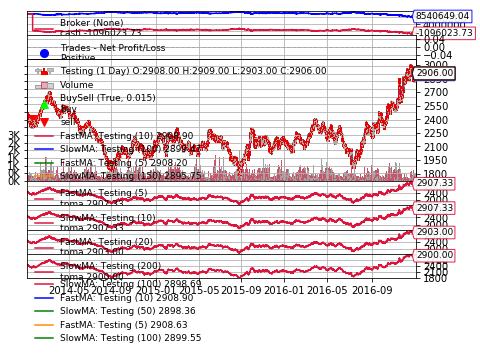

[[<Figure size 1152x648 with 8 Axes>]]

In [42]:
imagefile = "graph{}.png".format("finalRun")
datapath = join(getDataPath(),"Graph",imagefile)
cerebro.plot(style='candlestick', iplot=False, ytight=True, subplot=False, path=datapath)

In [ ]:
print ("Run,Ror")
for line in zip(training.keys(), training.values()):
    print ('{},{}'.format(*line))